# Load Data

In [483]:
#@markdown Run this cell to load the data. Show code to load a custom dataset. Double click this text to hide code.

#########################################
# Option 1: Load data from Google sheet #
#########################################

"""
The spreadsheet needs three subsheets, named "Votes", "Chart", "Titles"
Reference sheet: https://docs.google.com/spreadsheets/d/12QQ6aC2SsDjtlT7u5kcbFiKBAQWU0JA_rq2CEKciwTk/edit?usp=sharing
"""

SHEETNAME = '2000s Movies'
default_delimiter = ". " # Example vote: 1. [Film123]
special_delimiters = ["\) "] # Provide alterantive delimiters here, e.g. 1) [Film123]

##############################################################
# Option 2: Paste the vote matrix directly here as a string. #
##############################################################

vote_matrix_string = ""
vote_matrix_string = """ID,Title,aflickering,AinsleyIscariot,Allyn,amanda_online,Aruji,astadaradim,avalyn2,Bach,Blazko,BeepisBoopis,BlueSkies,bobohead61x,carlitos_go,Celebros,Cicadidae,comrade_sue,connordenney,crushedtoapulp,Cubbierill,darsu,daevalis,DeathOfSeasons,Dew1400,diction,Dolwphin,DtzaraD ,dukkha,Faure,goodsinginggum,Havey,hollowchatter ,Inovox,Iron_Dwarf,Jabbi,Jag114,JessieEye,JoLeKosovo,Josh318,jpzitoleopold,KnightToMourning,LifeDuringWartime,LowFidelity,Magenta_Bob,Meister333,MicrophoneFiend,momotaroyouth,moorezy,mrblond,mistercb,nadenrhys,nostalghia,nervalitis,NeverTrump,nivekwriter,novocaine69,Ohg,oscarmurraey,Ovals,peelsa,Rehtek ,Rengar18,rillo_raffy,russalex86,RuthJanelle,sesherhesher,Silverblack,she_esh,simo000,Sluggo714,spencership,Stoicorum,Strawhenge,SynysterShadows,tectactoe,thefeverayeaye,tonkatonka,tuukkis,YasashiiDia
Psychedelic Death Vomit],Psychedelic Death Vomit],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
The Road Becomes What You Leave],The Road Becomes What You Leave],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10000],Container,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10001],Speed Racer,18,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1001],回路 [Pulse],21,0,0,9,0,0,0,0,0,0,-1,0,0,0,0,0,22,0,0,0,0,0,0,0,0,31,48,10,0,0,27,0,0,0,0,0,0,0,5,8,0,0,0,0,0,0,0,0,0,0,48,3,0,0,0,0,0,4,0,0,1,0,0,0,3,0,37,0,0,0,0,0,0,0,0,0,0,0
[Film10023],Oh! Uomo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1002],叫 [Retribution],34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1003],ロフト [Loft],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1008],降霊 [Seance],36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10098],Nurse Betty,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1010],トウキョウソナタ [Tokyo Sonata],17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,14,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,33,0,0
[Film1016],The 40-Year-Old Virgin,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10186],The Heart of the World,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0
[Film10227],Bamako,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10243],House of Sand and Fog,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film102792],삼거리극장 [Midnight Ballad for Ghost Theater],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0
[Film10301],Monday,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1035],Shrek,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film10360],시간 [Time],0,0,0,0,9,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10371],Scooby-Doo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10392],In Absentia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film103],The Dark Knight,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,27,0,0,0,0,0,37,0,0,44,0,0,0,0,0,0,0,0,40,0,0,24,18,0,0
[Film104121],Foster's Home for Imaginary Friends: Destination Imagination,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10417],Lovesong,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0
[Film10426],Smiley Face,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10439],Cremaster 3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0
[Film10445],Light Is Waiting,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10447],No Direction Home: Bob Dylan,0,0,49,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10449],Public Enemies,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1049],Zoolander,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film1053],Anchorman: The Legend of Ron Burgundy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film10567],Mesrine : l'instinct de mort [Mesrine: Killer Instinct],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10568],復仇 [Vengeance],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10571],Mesrine : l'ennemi public n°1 [Mesrine: Public Enemy #1],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10584],ฟ้าทะลายโจร [Tears of the Black Tiger],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,39,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1059],鉄コン筋クリート [Tekkon Kinkreet],0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film105],The Lord of the Rings: The Two Towers,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,19,6,0,0,0,0,0,0
[Film1062],The Simpsons Movie,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film1063],Le scaphandre et le papillon [The Diving Bell and the Butterfly],0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,18,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0
[Film106480],Schuss!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film106482],Trains Are for Dreaming,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,47,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10661],Der Wald vor lauter Bäumen [The Forest for the Trees],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film106635],I-Be AREA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0
[Film10687],Shooting Dogs [Beyond the Gates],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10718],Sophie Scholl – Die letzten Tage [Sophie Scholl - The Final Days],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film107422],False Aging,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1079],劇場版 カウボーイビバップ 天国の扉 [Cowboy Bebop: Knockin' on Heaven's Door],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22
[Film107],The Lord of the Rings: The Return of the King,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,7,0,0,0,0,0,0
[Film10832],Le fate ignoranti [His Secret Life],0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10864],奇妙なサーカス [Strange Circus],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0
[Film108670],Ben 10: Secret of the Omnitrix,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film108954],映画 クレヨンしんちゃん 嵐を呼ぶ モーレツ!オトナ帝国の逆襲 [Crayon Shin-chan: The Storm Called: The Adult Empire Strikes Back],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film108],Dead Man's Shoes,0,0,0,0,0,40,0,0,0,0,-1,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10943],The Heart Is Deceitful Above All Things,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10974],Import/Export,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0
[Film10975],Vai e vem [Come and Go],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0
[Film10999],Los abrazos rotos [Broken Embraces],0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11006],The Life and Death of Peter Sellers,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11019],Honor de cavalleria [Honour of the Knights],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0
[Film11030],Nine Lives,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film110337],Alone in the Wilderness,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film110367],Samurai Jack: The Premiere Movie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film110369],Twas the Fight Before Christmas [The Powerpuff Girls: 'Twas the Fight Before Christmas],0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film110415],Camp Lazlo: Where's Lazlo?,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film110423],The Powerpuff Girls Rule!!!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1114],21 Grams,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0
[Film111866],Love's Refrain,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film111867],The Visitation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film111868],Threnody,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film111869],Song and Solitude,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film111877],Seasons...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11267],Horton Hears a Who!,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11283],茶の味 [The Taste of Tea],0,0,0,0,0,0,0,0,0,0,-1,0,0,42,0,0,0,7,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11361],Šílení [Lunacy],0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11365],The Imaginarium of Doctor Parnassus,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0
[Film11376],The Luzhin Defence,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11393],La veuve de Saint-Pierre [The Widow of Saint-Pierre],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film113],"O Brother, Where Art Thou?",0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,47,0,3,0,0,0,0,44,0
[Film114294],Yeti: A Love Story,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
[Film11466],Julia,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11527],Metallica: Some Kind of Monster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0
[Film11544],Birth,0,0,16,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0
[Film1159],Minority Report,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1164],一一 [Yi Yi],0,0,6,0,31,0,2,20,0,0,-1,3,0,22,7,0,0,2,0,2,0,0,0,1,40,0,9,13,0,0,0,0,0,4,6,1,0,0,9,0,0,0,0,-1,0,0,36,0,0,0,0,0,9,0,0,0,7,0,20,0,36,2,24,0,0,3,3,0,0,0,0,0,0,0,0,6,0,32
[Film11679],Crazy/Beautiful,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1176],Eastern Promises,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11778],طلای سرخ [Crimson Gold],0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11785],Che,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11787],Trolösa [Faithless],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11789],روزی که زن شدم [The Day I Became a Woman],0,22,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11799],The Hangover,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11812],취화선 [Painted Fire],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0
[Film11843],Los lunes al sol [Mondays in the Sun],0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film118779],Voiliers et coquelicots [Poppies and Sailboats],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film118783],Lampa cu caciula [The Tube with a Hat],0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11883],오! 수정 [Virgin Stripped Bare by Her Bachelors],0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1193],Adaptation.,0,0,0,0,0,0,46,0,3,0,0,0,44,0,46,0,0,0,0,0,0,0,27,21,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,21,0,0,0,0,0,0,0,33,0,0,21,25,0,33,0,0,36,0,0,0,34,0,0,0,42,4,0,0,0
[Film119651],Rehearsals for Retirement,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film11],Sunshine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0
[Film12058],Hot Rod,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film12078],Stuck,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1208],Punch-Drunk Love,42,0,29,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,23,0,0,0,1,0,0,0,0,0,0,0,0,47,0,31,0,0,0,0,32,0,0,0,0,0,11,30,0,0,23,0,0,5,12,0,11,0,9,0,0,2,0,0,0
[Film12096],O signo do caos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film12124],カミュなんて知らない [Who's Camus Anyway?],0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film121405],Guided by Voices,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1214],The Aviator,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1219],Juventude em marcha [Colossal Youth],0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,45,0,0,33,0,10,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0
[Film1221],花とアリス [Hana and Alice],0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1223],ユリイカ [Eureka],0,3,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,6,0,5,0,3,2,0,0,0,16,0,0,14,30,0,0,0,0,0,0,0,45,0,0,0,0,-1,0,31,0,0,3,0,0,0,4,0,0,0,10,46,9,0,0,10,0,0,0,0,25,0,0,0,0,0,0,0,26,26,0,0
[Film1225],"エリ・エリ・レマ・サバクタニ [My God, My God, Why Hast Thou Forsaken Me?]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1230],Kung Fu Panda,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44
[Film1231],Gangs of New York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0
[Film1234],No quarto da Vanda [In Vanda's Room],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,2,0,0,0,0,2,7,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,22,25,0,0,0,0,0,15,0,14,0,0,0,0,0,0,0,0,7,0,0
[Film1239],The Station Agent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0
[Film1240],Où gît votre sourire enfoui ? [Where Does Your Hidden Smile Lie?],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1250],The Assassination of Jesse James by the Coward Robert Ford,37,0,0,0,0,0,0,0,4,0,-1,0,0,0,0,0,0,0,0,0,47,37,15,0,0,0,0,0,0,0,0,0,0,25,42,0,0,0,0,0,0,0,16,-1,0,0,49,0,4,0,0,0,0,0,6,0,0,0,0,0,0,25,0,0,0,0,28,19,0,0,8,0,0,0,0,0,0,0
[Film1252],공동경비구역 JSA [J.S.A.: Joint Security Area],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film125551],Das Lied von den zwei Pferden [Two Horses of Genghis Khan],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1257],Last Days,0,0,0,0,0,0,17,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0
[Film12665],Τριλογία: Το λιβάδι που δακρύζει [The Weeping Meadow],0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film127119],Bouquets 21-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film127],28 Days Later...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,15,-1,0,0,0,0,0
[Film1282],Mystic River,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0
[Film1284],Million Dollar Baby,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,42,0,0
[Film1285],School of Rock,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0
[Film128734],Market Street,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film12902],R Xmas,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film12922],Fish Tank,0,43,0,0,0,0,43,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0
[Film129666],And We All Shine On,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film12969],Avatar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1296],Capote,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film12977],Die innere Sicherheit [The State I Am In],0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film12981],Toolbox Murders,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film12985],Jerichow,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1300],Shrek 2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0
[Film13116],Sugar & Spice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0
[Film1311],Far From Heaven,0,0,0,0,0,0,0,17,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1313],The Fountain,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0
[Film13222],鬼子來了 [Devils on the Doorstep],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1322],Harry Potter and the Prisoner of Azkaban,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,45,0,0,0,0,0,0,0,0
[Film13246],سگ‌های ولگرد [Stray Dogs],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1324],A History of Violence,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1334],Before Sunset,0,0,2,0,0,0,0,0,39,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,13,36,0,0,21,0,0,48,0,0,0,32,50,25,41,18,0,0,0,8,0,0,0,23,0,0,0,10,0,0,0,0,0,35,23,12,0,0,31,0,48,0,0,0,0
[Film1336],Harry Potter and the Order of the Phoenix,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1348],Vendredi soir [Friday Night],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,-1,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1355],Gerry,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0
[Film1356],"Paris, je t'aime [Paris, I Love You]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1358],Les amants réguliers [Regular Lovers],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film13597],Treasure Planet,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1360],Zwartboek [Black Book],0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0
[Film136150],Still in Cosmos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film136336],Frágil como o mundo [Fragile As the World],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1374],Y tu mamá también [And Your Mother Too],0,0,0,0,0,0,36,0,0,0,0,15,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,17,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1386],Babel,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1387],"봄 여름 가을 겨울 그리고 봄 [Spring, Summer, Autumn, Winter... and Spring]",0,37,0,0,38,0,0,0,0,0,0,18,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,33,0,50,0,0,0,20,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1391],In the Loop,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0
[Film13935],ดอกฟ้าในมือมาร [Mysterious Object at Noon],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0
[Film14129],Timecode,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1412],*Corpus Callosum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film14203],Heima,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0
[Film14223],Abril despedaçado [Behind the Sun],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1431],Låt den rätte komma in [Let the Right One In],0,0,0,0,0,0,33,0,0,0,-1,46,8,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,38,46,0,32,0,0,0,0,0,21,0,0,0,0,2,0
[Film14320],In Search of a Midnight Kiss,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0
[Film1436],Возвращение [The Return],0,47,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,49,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film14375],Tetro,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film14385],All or Nothing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film143956],Uncut Family,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1441],花樣年華 [In the Mood for Love],0,38,0,0,0,9,1,0,0,0,0,1,0,0,20,0,25,18,0,15,0,34,9,0,3,9,49,0,0,0,0,0,1,8,23,2,0,0,0,0,4,0,0,0,0,9,2,15,12,0,0,0,0,0,0,4,25,0,0,0,7,14,41,0,0,8,6,31,3,0,38,0,0,33,0,10,8,6
[Film1443],빈 집 [3-Iron],0,9,0,0,48,0,37,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,5,0,0,0,0,0,0,0,42,5,0,0,0,0,0,0,0,0,0,0,0,37,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27
[Film1449],ハウルの動く城 [Howl's Moving Castle],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,3,0,0,23,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,28,0,0,20,0,0,42,0,0,0,0,0,15
[Film14572],Whatever Works,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film145],The Virgin Suicides,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film14625],Rejected,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0
[Film1462],13 Lakes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1465],Burn After Reading,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,29,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0
[Film14699],Les amours d'Astrée et de Céladon [Romance of Astrea and Celadon],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film14701],La captive [The Captive],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film147],英雄 [Hero],0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,11,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film14806],ラブ&ポップ [Love & Pop],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film14809],式日 [Ritual],0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,18,0,0,0,0,0,0,0,14,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,-1,0,49,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,36
[Film14827],Disgrace,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film14864],転校生さよならあなた [Switching - Goodbye Me],0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film14901],リンダ リンダ リンダ [Linda Linda Linda],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10
[Film14903],好きだ、 [Su-ki-da],0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1491],A.I. Artificial Intelligence,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,29,0,0,1,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,1,26,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,22,0,0
[Film1499],Martyrs,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,16,0,0,0
[Film1502],呪怨 [Ju-on: The Grudge],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1505],"4 luni, 3 săptămâni şi 2 zile [4 Months, 3 Weeks and 2 Days]",0,20,0,0,0,37,0,0,9,0,0,0,0,0,0,0,0,42,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,46,46,6,35,0,30,41,0,0,0,0,0,0,0,0,0,5,0
[Film150],Hot Fuzz,0,25,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,41,0,0,45,0,0,50,0,0,0,19,0,12,-1,0,0,0,0,0
[Film1510],Bad Boys II,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0
[Film1511],Brand Upon the Brain!,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1512],東京残酷警察 [Tokyo Gore Police],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1517],Mysterious Skin,7,0,0,0,0,16,12,0,0,0,-1,47,42,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,5,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,13,0,0,0
[Film15214],Mary and Max.,0,45,0,0,0,20,0,0,0,0,0,0,0,0,43,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,7,0,0,0,0,0,-1,9,0,0,26,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,25,0,0,3,0,0,41
[Film1523],青い春 [Blue Spring],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film152],ねこぢる草 [Cat Soup],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,20,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0
[Film15324],20 centímetros [20 Centimeters],0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film153893],吸血 [Sanguivorous],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film153],No Country for Old Men,0,0,0,0,0,4,15,0,29,0,-1,0,4,0,0,0,50,0,0,0,0,0,14,0,0,0,0,0,36,0,0,0,0,0,12,47,0,0,0,0,0,6,14,-1,11,0,16,0,29,0,0,0,0,17,2,9,42,0,0,24,0,18,31,10,0,0,12,7,17,14,25,4,0,23,23,21,0,23
[Film154115],چراغی در مه [A Light in the Fog],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film15473],Love & Basketball,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0
[Film1553],Instructions for a Light and Sound Machine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,19,0
[Film1556],崖の上のポニョ [Ponyo],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,43,0,0,0,0,0,15,0,3
[Film1558],Decasia: The State of Decay,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1559],Kingdom of Heaven,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film155],Elephant,0,0,20,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,8,0,0,0,0,44,0,14,0,0,0,0,33,0,0,0,0,0,0,24,0,0,11,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0
[Film1562],Sånger från andra våningen [Songs From the Second Floor],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,3,0,0,0,0,7,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,36,0,0,-1,0,0,0,0,0,0,0,0,23,0,0,0,48,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0
[Film1564],"Du levande [You, the Living]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,26,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0
[Film15666],下妻物語 [Kamikaze Girls],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film15685],スウィングガールズ [Swing Girls],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1571],Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan,0,0,0,0,0,8,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film1574],誰も知らない [Nobody Knows],0,0,0,0,0,0,11,0,0,0,0,4,0,0,0,0,0,0,0,41,0,0,0,35,0,0,32,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,33,0,0,0,0,0,0,0,0,0
[Film1595],Русский ковчег [Russian Ark],0,0,9,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,11,16,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,7,0,0,0,0,0,0,0,0,0
[Film160633],Passion,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film161053],Stara škola kapitalizma [The Old School of Capitalism],0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1616],Finding Nemo,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,-1,0,0,0,0,0
[Film16173],Bad Lieutenant: Port of Call - New Orleans,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,15,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1619],2046,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,5,0,0,9,0,12,0,12,0,0,0,0,0,0,48,0,0,0,19,0,0,0,19,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,10,0,49,0,0,0,16,38,0,0,0,9,0,47,0,0,0,0,0,0,0,0,0,0
[Film16212],"My Son, My Son, What Have Ye Done",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,16,0,0,0,0
[Film1621],Juno,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film16236],Moon,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,35,0,0,0,0,0,0
[Film1633],"장화, 홍련 [A Tale of Two Sisters]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
[Film16396],Sin nombre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film164043],Sjaj u očima [Loving Glances],0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film16419],La libertad [Freedom],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1641],Code inconnu: Récit incomplet de divers voyages [Code Unknown: Incomplete Tales of Several Journeys],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film16446],Sherlock Holmes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film16494],Last Orders,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film16522],Angel,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film16523],Drôle de Félix [The Adventures of Felix],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1658],Little Miss Sunshine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0
[Film16727],"Poliţist, adjectiv [Police, Adjective]",0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film16752],(500) Days of Summer,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film16788],空気人形 [Air Doll],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,44,0,40
[Film1680],Der Untergang [Downfall],0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film16822],Citizen Toxie: The Toxic Avenger IV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0
[Film16833],あずまんが大王（劇場短編） [Azumanga Daioh: The Very Short Movie],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film16911],Un lac [A Lake],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1691],"좋은 놈, 나쁜 놈, 이상한 놈 [The Good, the Bad, the Weird]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0
[Film16940],The Call of Cthulhu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film16956],A Serious Man,0,0,0,0,0,7,0,0,37,0,0,0,0,0,0,38,8,0,0,0,3,0,0,0,0,0,0,0,30,0,23,0,0,0,0,0,0,0,0,0,23,0,0,-1,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,14,0,0,37,0,0,15,0,0,4,0,0,0,0,0,0,7,45
[Film17012],ヱヴァンゲリヲン新劇場版:破 [Evangelion: 2.0 You Can (Not) Advance],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33
[Film170392],Green Fuse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1704],時をかける少女 [The Girl Who Leapt Through Time],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,25,0
[Film17050],Dinosaur,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film170533],Kopfüber im Geäst [Hanging Upside Down In The Branches],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film170],올드보이 [Oldboy],0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,4,0,0,0,4,0,0,0,-1,13,0,0,0,14,0,0,0,0,18,0,0,39,0,0,9,12,11,0,0,0,21,38,0,16,0,13,22,0,0,49,37,0,0
[Film1710],千年女優 [Millennium Actress],30,0,0,0,42,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,34,4,0,0,0,0,0,0,0,0,17
[Film17139],Serras da desordem [The Hills of Disorder],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film171874],Superstarlet A.D.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film17230],Six Shooter,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film17237],12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film17330],The Soul of a Man,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0
[Film17446],생활의 발견 [On the Occasion of Remembering the Turning Gate],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1748],東京ゴッドファーザーズ [Tokyo Godfathers],0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,33,0,0,0,0,16,0,0,0,0,0,0,0,0
[Film17493],Tony Manero,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film17561],Ma vraie vie à Rouen [My Life on Ice],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film17580],Un baiser s'il vous plaît [Shall We Kiss?],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film175],Crank,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1769],How High,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film17787],Guard Dog,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0
[Film178],Dancer in the Dark,0,21,0,0,0,0,0,1,0,0,0,23,0,0,0,0,0,26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,20,0,0,0,0,28,0,0,0,0,35,0,4,0,0,0,0,0,6,0,0,22,0,14,0,0,0,0,0,14,0,4,8,0,0,0
[Film1790],秒速5センチメートル [5 Centimeters per Second],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0
[Film17926],Harry Potter and the Half-Blood Prince,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film17958],Trouble the Water,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film17967],スチームボーイ [Steamboy],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1805],Aqua Teen Hunger Force Colon Movie Film for Theaters,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film18092],Where the Wild Things Are,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film180],복수는 나의 것 [Sympathy for Mr. Vengeance],0,0,0,0,2,0,0,0,7,0,0,36,0,0,0,0,0,0,12,0,0,0,33,0,0,44,0,0,0,0,0,0,0,0,0,36,0,0,0,1,0,0,0,-1,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,44,0,0,0,0,0,36,0,0,0,0,4,0
[Film1811],The Others,0,0,0,0,0,0,9,4,0,0,-1,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1813],Traffic,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0
[Film18145],Now Showing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film18176],Seraphim Falls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film182021],Kenedi se ženi [Kenedi Is Getting Married],0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1825],Catch Me If You Can,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film18298],Hotel Chevalier,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film18336],Bronson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0
[Film1837],"Cześć, Tereska [Hi, Tereska]",0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film18398],J'ai toujours rêvé d'être un gangster [I Always Wanted to Be a Gangster],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film184502],紙屋悦子の青春 [The Blossoming of Etsuko Kamiya],0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1845],George Washington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,22,0,0,0,0,0,0,0,0,18,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film18515],Polytechnique,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1854],你那邊幾點 [What Time Is It There?],40,0,0,0,24,0,0,48,0,0,0,0,0,36,0,0,0,13,0,4,0,26,0,0,26,0,5,0,0,0,12,0,0,0,5,0,0,0,44,0,6,0,0,0,0,0,0,0,0,0,5,0,10,0,0,5,15,0,0,0,0,34,5,0,0,13,0,0,0,0,0,0,0,10,0,0,0,0
[Film1857],"不散 [Goodbye, Dragon Inn]",0,0,0,0,0,30,0,0,0,0,0,0,0,10,27,0,0,0,0,31,0,0,0,0,35,0,39,0,0,0,18,0,3,0,0,0,0,0,0,0,18,0,0,-1,0,36,0,0,0,0,14,0,19,0,0,0,0,0,18,0,0,31,27,0,0,0,0,0,0,26,0,0,0,29,0,25,0,0
[Film1858],天邊一朵雲 [The Wayward Cloud],0,0,0,0,0,0,0,15,0,0,0,0,0,12,5,0,0,49,0,0,0,0,0,0,12,24,11,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0
[Film18592],Life and Debt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1861],黑眼圈 [I Don't Want to Sleep Alone],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0
[Film1863],The Limits of Control,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0
[Film18650],風花 [Kaza-hana],0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film18655],铁西区 [Tie Xi Qu: West of the Tracks],0,0,0,0,0,0,0,0,0,0,0,0,0,25,28,0,0,0,46,0,0,29,0,0,0,0,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,14,0,34,0,0,0,0,0,0,1,2,0,2,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,4,0,0
[Film18659],采油日记 [Crude Oil],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0
[Film1870],"Synecdoche, New York",1,1,0,0,44,21,0,0,0,0,0,0,0,0,22,0,0,46,4,12,0,0,35,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,16,0,7,0,0,0,0,0,0,16,0,0,3,0,0,0,0,9,21,0,0,18,45,0,0,0,1,0,0,0,21,0,0,0
[Film1875],Spider-Man 2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,10,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,49,0,0,0,0,0,-1,0,0,0,0,0
[Film1878],Marie Antoinette,0,0,34,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film18795],南京! 南京! [City of Life and Death],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1880],"María, llena eres de gracia [María Full of Grace]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1882],Master and Commander: The Far Side of the World,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,40,0,0,0,0,0,0,0,0,0,0
[Film189237],Kenedi se vraća kući [Kenedi Goes Back Home],0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film18968],Quei loro incontri [These Encounters of Theirs],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film18971],Le genou d'Artémide [Artemis' Knee],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1898],Éloge de l'amour [In Praise of Love],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,17,7,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,7,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film18996],El cant dels ocells [Birdsong],0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film19005],Electroma,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film19027],The Home Song Stories,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1902],Bruce Almighty,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film190313],Tahousse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film19083],35 rhums [35 Shots of Rum],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,17,0,0,0,43,0,0,32,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0
[Film19126],Les femmes de l'ombre [Female Agents],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film19184],Battements solaires [Solar Beats],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1919],The Saddest Music in the World,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0
[Film191],Crank: High Voltage [Crank 2],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film1925],Love Actually,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1931],Bowling for Columbine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film19325],Aquele querido mês de agosto [Our Beloved Month of August],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film19342],Teknolust,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1935],8 Mile,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film19399],"Profils paysans, chapitre 3 : la vie moderne [Modern Life]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1939],สุดเสน่หา [Blissfully Yours],0,12,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,44,0,0,0,0,0,0,0,4,2,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,40,0,0,0,22,14,10,0,0,0,12,0,11,0,0,0,0,0,0,0,0,0,0,41,0,0
[Film19470],Les plages d'Agnès [The Beaches of Agnès],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0
[Film19499],Poultrygeist: Night of the Chicken Dead,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1964],À ma sœur ! [Fat Girl],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film19683],As I Was Moving Ahead Occasionally I Saw Brief Glimpses of Beauty,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,9,10,0,0,32,0,0,0,1,0,12,0,0,0,0,0,5,0,0,0,0,0,8,0,0,0,0,-1,0,0,10,0,0,0,0,4,0,0,0,0,1,0,1,0,0,50,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film19704],Der freie Wille [The Free Will],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1978],Jackass: The Movie,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,9,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film19880],ヴァーサス [Versus],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0
[Film198],친절한 금자씨 [Lady Vengeance],0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,29,0,0,0,0,0,0,0,0,0,0,0
[Film1992],2 Fast 2 Furious,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film19998],검은 땅의 소녀와 [With the Girl of Black Soil],0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,25,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film20087],밀양 [Secret Sunshine],0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,11,0,0,0
[Film20110],여자는 남자의 미래다 [Woman Is the Future of Man],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0
[Film20237],Saw VI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film20267],Cloudy With a Chance of Meatballs,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film20270],Jennifer's Body,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2031],House of 1000 Corpses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2038],I'm Not There.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film20489],The Twilight Saga: New Moon,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film20515],Domestic Violence,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2052],Old Joy,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2055],Wendy and Lucy,0,50,0,0,0,0,39,0,0,0,-1,0,0,0,0,0,13,41,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,29,0,0,0,0,8,0,37,0,0,0,0,36,0,0,0,37
[Film2057],ואלס עם באשיר [Waltz With Bashir],0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,18,0,0,0,0,0,0,0,0,0
[Film205],Kill Bill: Vol. 1,0,0,36,0,0,0,21,0,0,0,0,0,6,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,14,0,0,2,0,0,0,0,0,48,0,0,0,9,0,-1,23,46,0,18,1,0,0,0,0,25,0,0,0,0,0,8,0,0,18,13,0,0,0,0,0,13,0,19,-1,0,0,0,0,0
[Film2067],Billy Elliot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2075],Training Day,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film20790],The Road,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film207],Kill Bill: Vol. 2,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,-1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,23,0,20,0,0,0,45,0,0
[Film2085],Paranoid Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0
[Film20912],Bright Star,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film20953],Celestial Subway Lines/Salvaging Noise,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,15,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0
[Film2100],Mary,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,26,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2109],Go Go Tales,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2110],Demonlover,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2115],Clean,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0
[Film2125],Das weisse Band [The White Ribbon],0,0,0,0,0,0,24,31,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,13,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,5,0,0,0,3,0,38,0,0,0,14,0,11,0,35,0,0,0,27,13,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0
[Film212910],#37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film214711],Wind,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film21484],Afterschool,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0
[Film2155],The Incredibles,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,33,0,0,0,0,0,29,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0
[Film2167],Bad Santa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film216921],안다고 말하지 마라 [Don't Even Think You Know],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0
[Film21692],De l'origine du XXIe siècle [Origins of the 21st Century],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film21694],Liberté et patrie [Liberty and Fatherland],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2174],8MM,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2196],Twilight,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film22138],サマーウォーズ [Summer Wars],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film22172],Battle for Haditha,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2219],Mies vailla menneisyyttä [The Man Without a Past],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2234],The Squid and the Whale,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0
[Film22401],Il dono [The Gift],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2240],Happy Feet,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2241],珈琲時光 [Café Lumière],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2244],1408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2270],Forgetting Sarah Marshall,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film227],Dogville,16,2,42,0,0,13,0,12,0,0,0,0,0,0,44,20,0,15,0,0,21,0,1,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,8,0,36,2,8,0,20,0,0,0,31,40,24,0,40,0,0,3,0,0,22,49,0,5,0,0,0,38,0,0,0,0,0,0,0,0
[Film2293],24 Hour Party People,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,11,0
[Film2298],Manderlay,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2299],Deliver Us From Evil,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film23056],紀子の食卓 [Noriko's Dinner Table],27,0,0,0,27,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film23176],Hotel,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film23192],Valhalla Rising,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2320],Lilja 4-ever,0,0,0,0,0,0,20,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,25,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film23249],Моя любовь [My Love],0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2328],25th Hour,0,34,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2333],Pineapple Express,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0
[Film2338],สัตว์ประหลาด [Tropical Malady],0,44,8,0,45,0,0,0,0,0,-1,0,0,18,0,0,6,16,0,10,0,0,0,14,23,1,40,24,0,0,0,0,0,12,0,0,0,0,3,0,14,0,21,0,0,4,0,0,0,0,0,0,2,0,0,0,36,0,14,0,0,3,1,0,8,43,4,11,0,0,0,0,0,13,0,3,0,13
[Film23474],Halloween II,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,11,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film23616],고양이를 부탁해 [Take Care of My Cat],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0
[Film2366],Bug,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film236830],Leading to War,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2369],Touching the Void,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2374],Sicko,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film23771],Batang West Side [West Side Avenue],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film23772],Ang Pagdadalaga ni Maximo Oliveros [The Blossoming of Maximo Oliveros],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film24047],Edifício Master [A Building in Copacabana],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2415],Femme Fatale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film241],十面埋伏 [House of Flying Daggers],0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2424],WALL·E,0,0,0,0,0,0,0,0,0,17,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,5,0,0,24,0,0,0,0,0,8,0,0,0,0,0,0,0,0,48,30,0,0,0,0,5,0,0,0,-1,34,0,0,0,48
[Film24256],Pontypool,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0
[Film24262],我左眼見到鬼 [My Left Eye Sees Ghosts],32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film24279],Κυνόδοντας [Dogtooth],45,0,33,0,0,0,14,0,0,0,-1,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,7,0,0,32,41,0,0,0,0,0,0,0,36,0,47,0,0,44,0,6,4,0,0,0,50,0,6,0,30,0,0,44,43,0,0,0
[Film24281],Le père de mes enfants [The Father of My Children],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2437],L' enfant [The Child],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0
[Film2440],Halloween,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2441],Le silence de Lorna [Lorna's Silence],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2443],Солнце [The Sun],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film24454],थे लीजेंड ऑफ़ भगत सिंह [The Legend of Bhagat Singh],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2447],功夫 [Kung Fu Hustle],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,24,0,0
[Film2450],Le fils [The Son],8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0
[Film2458],살인의 추억 [Memories of Murder],24,0,10,0,0,28,0,0,0,0,-1,0,0,0,0,0,0,0,9,0,31,0,0,0,0,0,0,0,0,0,29,0,0,0,18,9,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,19,0,0,14,0,0,10,23,0,8,0,0,0,17,15,23,0,26,0,0,0,0,0,10,5
[Film24616],De grote vakantie [The Long Holiday],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2470],La ciénaga [The Swamp],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,21,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2475],A Scanner Darkly,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film24778],Hazard,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film247],殺し屋1 [Ichi the Killer],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,12,43,0,0,0,0,0,0,0
[Film2483],Primer,0,0,48,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,46,0,0,0,30,0,0,0,0
[Film24872],멋진 하루 [My Dear Enemy],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film24980],人が人を愛することのどうしようもなさ [The Brutal Hopelessness of Love],0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film25109],District 9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,31,0,-1,0,0,0,0,0
[Film251],Eternal Sunshine of the Spotless Mind,0,0,0,0,8,0,13,14,0,0,-1,0,15,0,0,0,0,0,0,0,25,0,0,48,0,0,0,0,18,0,21,0,0,0,0,50,0,4,0,0,0,0,0,-1,43,0,6,0,11,0,0,0,21,9,0,0,13,0,0,40,24,28,0,0,0,0,0,50,0,0,0,17,0,0,15,0,0,28
[Film2529],顺流逆流 [Time and Tide],0,0,0,7,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2533],蜀山傳 [The Legend of Zu],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2556],青红 [Shanghai Dreams],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film255],"싸이보그지만 괜찮아 [I'm a Cyborg, but That's OK]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0
[Film25638],The Meaning of Life,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2565],Bloody Sunday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2568],Brick,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0
[Film2574],Inglourious Basterds,0,0,0,0,34,0,0,0,0,0,0,0,34,0,0,10,0,0,0,0,0,0,0,39,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,19,0,0,0,0,7,0,0,0,0,0,2,0,0,10,0,47,0,13,0,0,32,0,13,-1,0,35,0,0,16
[Film2584],AVP: Alien vs. Predator,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2587],Dawn of the Dead,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2594],Iron Man,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0
[Film2600],Hunger,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,6,44,0,0,0,0,0,0,0,0,0,46,0,0,0
[Film2615],Stellet Licht [Silent Light],0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0
[Film26176],"Dance Party, USA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film26217],Karaula [The Border Post],0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film26247],Liverpool,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film26250],Black Dynamite,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,34,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0
[Film26303],State Legislature,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2630],The Fast and the Furious: Tokyo Drift,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0
[Film2633],The Terminal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2635],沙羅双樹 [Shara],0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film263],Requiem for a Dream,0,0,0,0,35,0,0,0,14,0,0,12,35,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,32,0,30,0,0,0,0,0,0,0,21,43,50,26,0,0,0,32,0,0,0,0,0,0,19,9,24,0,0,0,35,0,0,25,0,0,0,0,0,14,0,0,0
[Film2642],Um filme falado [A Talking Picture],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film26449],...درباره الی [About Elly],0,0,19,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2648],Inside Man,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2652],War of the Worlds,0,0,45,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2663],The Ring,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0
[Film26757],Falsa loura [Fake Blond],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2684],少林足球 [Shaolin Soccer],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film2693],11:14,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film269],달콤한 인생 [A Bittersweet Life],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,43,14,0,0,0,0,0,0,0,0,0,0
[Film27035],봄날은 간다 [One Fine Spring Day],0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film27061],Singularidades de uma rapariga loura [Eccentricities of a Blonde-Haired Girl],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2721],愛のむきだし [Love Exposure],3,0,3,0,1,0,0,0,0,0,-1,41,0,31,10,0,0,0,27,36,0,16,0,0,0,22,38,0,0,0,0,0,0,2,0,0,1,0,37,11,0,0,0,-1,15,29,0,0,28,0,0,0,0,0,5,0,9,0,0,1,0,0,0,0,12,4,0,3,0,0,0,0,-1,0,6,0,0,7
[Film2724],Death Proof,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,6,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,11,0,0,0,0
[Film2729],たそがれ清兵衛 [The Twilight Samurai],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,36,0,16,0,0,0,0,0,29,0
[Film2734],Sideways,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0
[Film2736],The King of Kong,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0
[Film27375],tokyo.sora,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,13,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film27383],顔 [Face],0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2740],The Kid Stays in the Picture,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film27520],Bones,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2759],American Splendor,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0
[Film276],The Man Who Wasn't There,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,3,0,0,32,0,0,0,0
[Film2776],House of Wax,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film27805],Casa de areia [House of Sand],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film27873],마더 [Mother],0,0,0,0,23,44,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,24,16,0,0,0,0,0,0,0,0,0,31,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,48,22,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2789],Mission to Mars,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2791],Best in Show,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film27],Lost in Translation,0,0,1,0,0,0,4,27,2,0,-1,0,40,0,0,0,0,0,48,47,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,18,11,0,9,0,0,0,37,0,23,0,31,0,0,0,33,4,0,0,0,0,0,0,0,0,0,27,0,28,0,0,0,18
[Film280],Donnie Darko,0,0,0,0,0,0,10,0,0,0,0,14,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,9,0,0,0,0,0,0,44,0,8,0,0,0,0,18,0,3,0,0,0,6,0,0,0,13,0,7,0,0,0,0,30,0,0,0,0,38,6,0,0,0,0,0,18,0,0,28,0,0,0
[Film2819],転々 [Adrift in Tokyo],0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,28,0,0,0,0,0,0,0,0,0
[Film2827],Resident Evil,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,22,17,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2838],W.,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2868],The Fog of War: Eleven Lessons From the Life of Robert S. McNamara,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0
[Film2869],Hedwig and the Angry Inch,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0
[Film2879],You Can Count on Me,0,0,24,0,0,0,0,0,0,0,0,44,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2882],Baby Boy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film288],Mulholland Dr.,5,8,5,0,4,3,6,11,0,0,-1,42,5,0,8,34,4,9,3,16,5,0,4,4,37,8,18,1,5,0,8,0,0,0,0,5,0,0,6,20,0,5,2,-1,8,17,24,0,7,0,8,0,34,0,0,2,16,41,0,6,2,12,2,9,9,12,23,8,0,5,5,46,0,7,1,5,0,2
[Film2905],Jackass Number Two,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0
[Film2914],Half Nelson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film291],Shaun of the Dead,0,7,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,-1,0,0,0,0,30
[Film29200],Rembrandt's J'accuse...!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,17,0
[Film2920],Happy-Go-Lucky,22,0,21,0,0,0,42,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,31,0,0,0,0,0,0,0,0,0,0,0
[Film29263],Lake Mungo,0,0,0,12,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film2929],The Room,0,0,0,0,0,10,0,0,0,0,-1,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,24,0,0,0,0,0,0,0,0,0,0
[Film293],Hable con ella [Talk to Her],0,0,0,0,0,14,0,22,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,32,0,0,0,0,0,39,0,0,0,0,0,0,43,0,0,0,0,0,0,0,7,0,0,0,0,48,0,0,0
[Film29445],ノロイ [Noroi: The Curse],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film29603],Trash Humpers,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,46,0,0,0,0,21,0,0,0,0,0,0,0,0
[Film2960],Yella,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film29783],二十四城记 [24 City],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,45,9,0,0,0,0,0,0,0,0,40,0,0
[Film2980],Gideon's Daughter,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film29834],Life Is Hot in Cracktown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0
[Film2993],Dig!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0
[Film3002],Storytelling,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0
[Film30094],De ofrivilliga [Involuntary],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film30137],الزمن المتبقي [The Time That Remains],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3018],Rachel Getting Married,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0
[Film301],Snatch,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,44,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,14,0,44,0,-1,0,0,0,0,0
[Film302],Das Leben der Anderen [The Lives of Others],0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,3,0,0,0,0,45,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,12,29,0,0,0,0,0,0,0,0,19,0,0,0,0,10,0,0,0,0,0,0,0,0,0
[Film30571],ओम शान्ति ओम [Om Shanti Om],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3063],Le pacte des loups [Brotherhood of the Wolf],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film30653],L' enfer d'Henri-Georges Clouzot [Henri-Georges Clouzot's Inferno],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0
[Film30909],Cleópatra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film310],Team America: World Police,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0
[Film31114],New Town Killers,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3113],六月の蛇 [A Snake of June],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3114],La môme [La vie en rose],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3116],無間道 [Infernal Affairs],0,0,0,0,0,39,29,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,27,45,0,0,0,0,0,0,0,0,0,25
[Film3117],トニー滝谷 [Tony Takitani],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3124],ビジターQ [Visitor Q],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0
[Film3143],Rois & reine [Kings and Queen],12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3150],Un conte de Noël [A Christmas Tale],14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3166],Notre musique [Our Music],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0
[Film31693],"New York, I Love You",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film31714],Gentlemen Broncos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3185],ヴィタール [Vital],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3187],ヘイズ [Haze],0,40,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3193],The Fall,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3202],Keane,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,9,0,0,0,0,0,0,0
[Film3212],三峡好人 [Still Life],0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,37,32,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0
[Film32238],Up in the Air,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film324],Chocolat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3252],En la ciudad de Sylvia [In the City of Sylvia],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,34,0,50,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film325],Cidade de Deus [City of God],0,0,0,0,0,0,23,0,0,0,-1,26,0,0,21,17,0,0,0,0,0,0,6,3,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,-1,0,0,21,0,16,0,0,0,0,0,0,0,30,0,0,4,0,0,25,34,0,0,0,0,8,0,0,0,0,0,25,0,0,24
[Film3263],Wesele [The Wedding],0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film32642],True to Life,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film32686],Ветер вдоль берега [Wind Along the Coast],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0
[Film32688],Дождь сверху вниз [Rain Down From Above],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0
[Film327],Memento,0,0,23,0,5,0,0,47,18,0,0,0,0,0,0,8,0,0,29,39,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,17,0,2,0,0,18,0,39,0,25,0,0,0,0,20,14,0,0,0,0,28,0,0,9,43,0,0,21,0,0,28,0,28,0,18,0,0,0,0
[Film3281],Lars and the Real Girl,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3285],Mùa hè chiều thẳng đứng [The Vertical Ray of the Sun],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3289],L' ora di religione (Il sorriso di mia madre) [My Mother's Smile],0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3290],Letters From Iwo Jima,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3305],Milk,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film330],Gladiator,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,43,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0
[Film33284],Sir! No Sir!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film33358],RR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film333],Sin City,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,45,0,0,0
[Film33408],Casting a Glance,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3340],Talladega Nights: The Ballad of Ricky Bobby,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film33442],To End All Wars,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3344],Hellboy II: The Golden Army,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film33525],Адажио [Adagio],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,22,0
[Film33534],White Material,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film33535],Lola [Grandmother],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film33802],Film ist. 7-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film33838],Lourdes,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3385],Atonement,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film33860],Mal día para pescar [Bad Day to Go Fishing],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0
[Film338],Star Wars Episode III: Revenge of the Sith,0,0,0,5,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,35,0,50,0,0,0,0,15,0,0,0,0,0,0,5,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film3391],L' intrus [The Intruder],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film339],Napoleon Dynamite,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film34164],Mr. Nobody,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film34271],Le pont des Arts [The Bridge of Arts],0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,26,0,17,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film343],The Matrix Reloaded,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film34507],Combat d'amour en songe [Love Torn in a Dream],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0
[Film3455],Domino,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3462],Bamboozled,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3473],"La Commune (Paris, 1871)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film347],Star Wars Episode II: Attack of the Clones,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,8,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3481],Once,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3486],One Hour Photo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film348],The Matrix Revolutions,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film35004],Snijeg [Snow],0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film35036],Une visite au Louvre [A Visit to the Louvre],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film35049],Les savates du bon Dieu [Workers for the Good Lord],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film35145],ゴジラ FINAL WARS [Godzilla: Final Wars],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film35354],El secreto de sus ojos [The Secret in Their Eyes],0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film35367],"히말라야, 바람이 머무는 곳 [Himalaya, Where the Wind Dwells]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film354],Volver [Return],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0
[Film35509],Revengers Tragedy,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film35547],Alle Anderen [Everyone Else],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0
[Film35592],A Single Man,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3565],Wszyscy jesteśmy Chrystusami [We're All Christs],0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film35925],J'ai tué ma mère [I Killed My Mother],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film35997],بید مجنون [The Willow Tree],0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film360],Tideland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0
[Film3613],The SpongeBob SquarePants Movie,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39
[Film3638],Erin Brockovich,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0
[Film363],Good Bye Lenin!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3642],The Last Samurai,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0
[Film36496],Black Sun,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0
[Film3656],Trouble Every Day,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,44,0,0,0,0,0,0,0,25,0,27,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film36598],Warming by the Devil's Fire,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3662],Deja Vu,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film36807],Triangle,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film36870],De Helaasheid der dingen [The Misfortunates],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film36885],잘 알지도 못하면서 [Like You Know It All],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0
[Film36891],The Fourth Dimension,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film368],Shortbus,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3713],Non ho sonno [Sleepless],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film37179],Frontrunners,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film371],The Brown Bunny,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,31,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,2,0,0,0,0
[Film372],Le conseguenze dell'amore [The Consequences of Love],0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3740],Persepolis,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,31,0
[Film3745],Saraband,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3750],千禧曼波 [Millennium Mambo],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,7,17,0,0,33,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3764],Blinkende lygter [Flickering Lights],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0
[Film37659],落叶归根 [Getting Home],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0
[Film3786],"Monsters, Inc.",0,0,40,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,-1,0,0,0,0,0
[Film3789],最好的時光 [Three Times],0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0
[Film3795],Der Baader Meinhof Komplex [The Baader Meinhof Complex],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film37961],I Am So Proud of You,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film38084],Day Night Day Night,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0
[Film3815],Uzak [Distant],0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0
[Film3827],Morvern Callar,46,0,0,0,0,11,27,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film38416],Panique au village [A Town Called Panic],0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film38450],Os famosos e os duendes da morte [The Famous and the Dead],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film38528],La nuit des horloges [The Night of the Clocks],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film38589],A religiosa portuguesa [The Portuguese Nun],0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film38590],Toutes les nuits [Every Night],0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film38591],Le monde vivant [The Living World],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0
[Film38610],Phoenix Tapes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film38647],Horizontal Boundaries,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3864],My Winnipeg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,45,27,0,0,0,0,0,47,0,0,0,15,0,0,0,0,12,44,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0
[Film3866],À l'intérieur [Inside],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3871],Antichrist,0,0,0,0,0,6,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,23,0,0,0,0,0,0,0
[Film3873],Gegen die Wand [Head-On],0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film38898],Magnifico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3891],Visage [Face],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0
[Film3900],Wristcutters: A Love Story,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0
[Film3915],站台 [Platform],0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,14,11,0,8,0,44,0,46,0,0,47,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0
[Film391],Almost Famous,0,0,0,0,0,0,7,0,0,0,0,32,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,22,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3928],White Chicks,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film3939],Gone Baby Gone,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film393],Batman Begins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film3940],Bedazzled,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film39417],Death to the Tin Man,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0
[Film3946],May,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4012],DEAD LEAVES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4017],Red Dragon,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film40281],Frownland,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0
[Film40344],Sogobi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,36,0,22,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film40345],Ten Skies,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,6,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,38,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film40439],Les jours où je n'existe pas [The Days When I Do Not Exist],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film40531],I Capture the Castle,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film40558],Seitsemän laulua tundralta [Seven Songs From the Tundra],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0
[Film405],This Is England,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,30,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0
[Film40755],La morte rouge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film40901],Candy Von Dewd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4092],Open Range,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0
[Film4099],Frida,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4101],Next,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film41020],Ruhr,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,24,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4103],Little Children,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4104],A londoni férfi [The Man From London],0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4106],Rambo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0
[Film4117],Histoire de Marie et Julien [The Story of Marie and Julien],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film412],Psycho Beach Party,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film41323],Ce jour-là [That Day],0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film41324],Desierto adentro [Deep Into the Desert],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film41352],Apan [The Ape],0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film413],The Bourne Supremacy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4154],El espinazo del Diablo [The Devil's Backbone],0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film41607],The Carter,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4166],Spider,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4172],เรื่องรัก น้อยนิด มหาศาล [Last Life in the Universe],0,4,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,33,0,4,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,42,0,0,0,0,0,0,0
[Film4174],คำพิพากษาของมหาสมุทร [Invisible Waves],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0
[Film4175],พลอย [Ploy],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film41823],The Living and the Dead,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film41831],Ghosts,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4188],Ničija zemlja [No Man's Land],0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film41893],El valley centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film418],The Bourne Identity,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,39,0,0,0,0,0,0,0,0,0,0
[Film4211],自殺サークル [Suicide Club],0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4212],黑社會 [Election],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,35,0,0,0,0,47,0,0
[Film4213],黑社會:以和為貴 [Election 2],31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4214],放‧逐 [Exiled],0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,48,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0
[Film4216],文雀 [Sparrow],38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4217],神探 [Mad Detective],0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,39,0
[Film4218],大隻佬 [Running on Karma],25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film42191],3 इडियट्स [3 Idiots],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4219],全职杀手 [Fulltime Killer],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0
[Film4221],Eden Lake,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4237],The Emperor's New Groove,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,27,0,0,0,0,0,0,0,0
[Film4248],Kiss Kiss Bang Bang,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0
[Film4252],Diarios de motocicleta [The Motorcycle Diaries],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4262],آفساید [Offside],0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,14
[Film4264],الجنّة الآن [Paradise Now],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4296],Chicken Run,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film4297],Cowards Bend the Knee,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4302],"Dude, Where's My Car?",0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film43068],Opération lune [Dark Side of the Moon],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film430],The Pianist,0,0,0,0,0,0,0,23,43,0,0,5,0,0,0,46,0,0,0,0,44,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,12,0,0,0,0,0,0,15,0,0,0,0,0,44,0,0,41,0,0,0,0,15,0,0,0,0,0,0,0,0,42
[Film4313],괴물 [The Host],0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,-1,0,0,17,0,0
[Film43221],蘇りの血 [The Blood of Rebirth],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4365],Pride & Prejudice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4397],Billy and Mandy's Big Boogey Adventure,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4422],[REC],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film44298],김씨 표류기 [Castaway on the Moon],0,0,0,0,0,0,0,25,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,9
[Film4432],嫌われ松子の一生 [Memories of Matsuko],0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0
[Film4437],Hulk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4439],Die Fälscher [The Counterfeiters],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4441],Funny Ha Ha,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film45061],L' uomo che verrà [The Man Who Will Come],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film45159],Sweetgrass,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film454],Big Fish,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0
[Film455],Cast Away,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film456],Depuis qu'Otar est parti... [Since Otar Left...],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film458],In Bruges,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,17,0,21,0,0,0,0,0,46,0,0,47,0,0,0,0,0,11,0,0,18,0,0,0
[Film464],Planet Terror,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4656],Of Time and the City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4670],La mujer sin cabeza [The Headless Woman],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4673],Gouttes d'eau sur pierres brûlantes [Water Drops on Burning Rocks],0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4680],Vera Drake,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film46856],The Secret of Kells,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0
[Film46927],Winter's Bone,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4697],Mission: Impossible III,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film470],Children of Men,0,0,0,0,0,18,0,0,6,0,-1,13,38,0,0,5,0,0,0,0,19,0,23,0,0,0,0,0,0,0,38,0,0,0,0,11,0,0,0,7,0,0,0,0,0,0,4,0,39,0,0,0,0,1,12,0,0,0,0,0,0,0,0,2,0,0,0,13,0,0,24,49,0,0,44,0,0,11
[Film47360],สัตว์วิกาล [Vampire],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film473],バトル・ロワイアル [Battle Royale],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,47,0,0,0,0,0,0,0,0,0,0,31,0,23,0,0,31,0,0,0,0,0,0,0,-1,0,0,0,0,46
[Film4747],Click,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film47752],Double Tide,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4777],Hellboy,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film47805],White Lightnin',0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4793],Madagascar,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film479],Star Trek,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film48001],Kordon [The Cordon],0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film48446],Amer,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4846],The Queen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0
[Film4859],춘향뎐 [Chunhyang],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
[Film48623],虹の女神 [Rainbow Song],0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film48805],White Light/Black Rain: The Destruction of Hiroshima and Nagasaki,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0
[Film4894],Les glaneurs et la glaneuse [The Gleaners and I],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,13,0
[Film4904],Legally Blonde,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4909],I Know Who Killed Me,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4912],ディスタンス [Distance],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4913],歩いても 歩いても [Still Walking],0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,17,0,44,0,0,0,2,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,15,0,0,0,24,0,0,0,0,16,0,31,0,0,34,9,0,0,0,0,0,0,0,0,0,20
[Film4924],ナイン・ソウルズ [9 Souls],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4930],Up,0,0,0,0,0,0,0,0,0,16,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,47,0,0,0,0,0,0
[Film4934],Drag Me to Hell,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film4943],United 93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film49534],Reindeerspotting: Pako Joulumaasta [Reindeerspotting: Escape From Santaland],0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film49540],카페 느와르 [Café Noir],0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,46,0,1,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
[Film4996],Memoirs of a Geisha,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film50014],Dans le noir du temps [In the Darkness of Time],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5008],Pusher 3,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film50249],Aka Ana,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film502],American Psycho,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,43,0,0,0,0,0,0,30,48,0,33,0,0,-1,0,19,0,0,0
[Film5054],The Reader,0,0,0,0,0,0,0,16,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film50661],Reel Injun,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film508],"臥虎藏龍 [Crouching Tiger, Hidden Dragon]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0
[Film50],Inland Empire,0,35,0,1,0,1,0,30,0,0,-1,0,0,0,0,24,44,1,0,0,1,21,0,0,4,40,33,18,0,0,3,0,0,0,0,0,12,0,0,0,0,0,0,-1,35,30,0,0,0,0,47,0,0,0,0,0,17,34,0,23,0,0,49,0,1,1,33,0,0,3,0,0,0,0,0,35,0,38
[Film5107],Secretary,0,0,0,0,0,0,47,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5109],8 femmes [8 Women],0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film51203],Ebolusyon ng Isang Pamilyang Pilipino [Evolution of a Filipino Family],0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film51206],Kagadanan sa Banwaan ning mga Engkanto [Death in the Land of Encantos],0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film512],Freddy Got Fingered,0,0,0,11,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,3,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5130],El orfanato [The Orphanage],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5131],Sweet Sixteen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5137],The Descent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film51617],牛皮贰 [Oxhide II],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5183],آوازهای سرزمین مادری‌ام [Marooned in Iraq],0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film51847],パッチギ! [Break Through!],0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film51892],Κινέττα [Kinetta],0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5192],لاک پشت ها هم پرواز می کنند [Turtles Can Fly],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29
[Film5195],Niwemang [Half Moon],0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film52508],Dead End Run,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5265],Michael Clayton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,27,0,0,0,0
[Film5296],Bicho de sete cabeças [Brainstorm],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5326],Step Brothers,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film532],Brokeback Mountain,0,0,0,0,0,0,0,2,0,0,0,10,27,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,15,22,0,0,0,0,0,0,30,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5331],The Dreamers,0,0,0,0,0,0,0,3,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film53454],Demain on déménage [Tomorrow We Move],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film53463],A State of Mind,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0
[Film5364],Nacho Libre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film54049],Lettre d'un cinéaste à sa fille [Letter From a Filmmaker to His Daughter],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film54116],孤男寡女 [Needing You...],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film54119],鏡心 [Mirrored Mind],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5412],La graine et le mulet [The Secret of the Grain],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5437],ده [Ten],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,28,0,0,0,25,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0
[Film54482],Kolme viisasta miestä [Three Wise Men],0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5448],カタクリ家の幸福 [The Happiness of the Katakuris],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0
[Film5449],The Mist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0
[Film5450],13 Going on 30,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5466],Barnyard,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film54852],The Black Dog's Progress,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film55292],เจ้านกกระจอก [Mundane History],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5529],世界 [The World],0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,19,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,13,0,0,39,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film55377],We Are The Strange,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film55416],Dying at Grace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film554],Vicky Cristina Barcelona,0,0,0,0,0,0,0,0,31,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film558],La science des rêves [The Science of Sleep],0,0,0,0,0,0,0,13,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5627],Sweeney Todd: The Demon Barber of Fleet Street,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5634],De fem benspænd [The Five Obstructions],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0
[Film5636],Jesus Camp,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film56535],河童のクゥと夏休み [Summer Days With Coo],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5656],The Wind That Shakes the Barley,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,45,0
[Film56592],アサルトガールズ [Assault Girls],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5670],Ice Age,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film5681],Miss Congeniality,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5688],The Proposition,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,29,0,0,0,0,0,0,0
[Film5696],Tenacious D in The Pick of Destiny,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film57117],Al primo soffio di vento [At the First Breath of Wind],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film574],パプリカ [Paprika],0,36,0,0,41,0,0,0,0,0,0,39,0,0,4,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,37,0,0,28,0,0,0,50,0,0,0,0,0,0,27,0,6,0,0,0,0,0,0,0,0
[Film57591],At Sea,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,45,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5768],Frailty,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5769],Machuca,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5771],Auf der anderen Seite [The Edge of Heaven],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film578],Watchmen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film5793],Ma mère [My Mother],0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5794],Choses secrètes [Secret Things],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film57],The Royal Tenenbaums,11,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,13,0,0,0,3,15,30,0,0,0,0,0,0,0,20,0,0,0,0,44,0,22,0,8,0,0,0,0,0,0
[Film5812],Den brysomme mannen [The Bothersome Man],0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film58282],めざめの方舟 [Open Your Mind],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film582],Gomorra [Gomorrah],0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5832],The Curse of the Jade Scorpion,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5851],L' imbalsamatore [The Embalmer],0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film59055],After Last Season,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5938],Brüno,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5951],Ginger Snaps,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film5955],Chłopaki nie płaczą [Boys Don't Cry],0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film59635],Alamar [To the Sea],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film597],Death to Smoochy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0
[Film59],The Life Aquatic With Steve Zissou,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,38,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,41,0,1,0,12,0,0,0,0
[Film6029],Bully,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film60842],Compline,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film60961],"Napoli, Napoli, Napoli",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film61056],Маяк [The Lighthouse],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0
[Film610],Scary Movie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film6120],Fantastic Mr. Fox,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,29,35,0,0,0,0,29,0,0,0,0,0,0,0,36,35,0,0,0,0,0,0,0,0,0,0,20,0,23,0,35
[Film6128],Candy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6130],オペレッタ狸御殿 [Princess Raccoon],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0
[Film6131],Sexy Beast,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0
[Film6137],Good Dick,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6166],The Devils,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film616],Les triplettes de Belleville [The Triplets of Belleville],0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,47,0,0,29,0,0,0,0,18,0
[Film6179],Män som hatar kvinnor [The Girl With the Dragon Tattoo],0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6202],La meglio gioventù [The Best of Youth],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,34,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6208],Dream Work,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
[Film62096],균열의 몫 [Cracked Share],0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6224],Элегия дороги [Elegy of a Voyage],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6232],The Yards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film623],Cloverfield,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film6255],Wallace & Gromit: The Curse of the Were-Rabbit,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6269],پنج [Five],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6295],We Own the Night,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film629],Be Kind Rewind,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film62],Control,0,0,0,0,0,0,0,36,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6306],Two Lovers,6,0,0,0,0,0,0,0,38,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film63194],"Trees of Syntax, Leaves of Axis",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,9,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,23,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0
[Film631],極道恐怖大劇場 牛頭 Gozu [Gozu],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,45,0,0,0,0,0,40,0,0,0,0,28,0,0,0,0,0,0,0
[Film6323],Man on Wire,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film632],Le fabuleux destin d'Amélie Poulain [Amélie],0,0,0,0,18,0,35,0,0,0,-1,11,24,0,0,39,0,0,13,0,0,0,0,9,0,0,0,0,0,0,0,0,0,7,0,23,0,17,0,0,0,0,0,0,17,0,0,3,15,0,0,0,41,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,4,10,0,0,0,0,0,0
[Film6330],Quills,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6344],Capturing the Friedmans,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0
[Film6374],柔道龍虎榜 [Throw Down],35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6376],PTU [PTU: Police Tactical Unit],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film63826],In Order Not to Be Here,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film639],千と千尋の神隠し [Spirited Away],43,11,25,0,0,0,16,0,0,0,-1,2,0,0,50,1,0,0,0,6,42,0,0,0,0,35,37,3,7,0,40,1,0,0,0,6,0,0,50,0,0,0,0,-1,1,8,0,0,30,0,0,0,0,4,0,0,6,0,0,26,3,49,16,0,6,2,32,2,1,25,0,16,0,0,39,0,1,1
[Film6408],Chicken Little,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film6413],Die Höhle des gelben Hundes [The Cave of the Yellow Dog],0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film64193],Redline,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0
[Film643],Southland Tales,0,0,0,6,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,21,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film645],Wet Hot American Summer,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6461],Tarnation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6462],おくりびと [Departures],0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6468],The United States of Leland,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film646],The Prestige,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,21,0,0,0,17,0,0,0,0,48,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,47
[Film6473],Charlie Wilson's War,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6477],Dear Zachary: A Letter to a Son About His Father,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0
[Film6485],Doubt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6488],Pootie Tang,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film64],The Darjeeling Limited,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film65010],High School Record,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film651],The New World,9,0,7,0,0,0,19,0,0,0,0,0,0,40,0,0,11,0,0,0,24,0,0,10,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,17,0,0,0,45,0,11,0,0,0,0,0,0,0,4,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0
[Film6528],Moartea domnului Lăzărescu [The Death of Mr. Lazarescu],0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,29,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0
[Film65313],Le plein pays [The Full Country],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film655],Le temps du loup [Time of the Wolf],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6565],You Don't Mess With the Zohan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film6567],Palindromes,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6574],Život je čudo [Life Is a Miracle],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film659],La pianiste [The Piano Teacher],0,0,0,0,0,0,0,9,0,0,-1,0,0,0,49,0,0,0,39,0,40,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,43,22,0,0,0,0,0,0,0,0,37,0,0,0
[Film6610],Blood Tea and Red String,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6662],Everything Will Be OK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film66843],Correspondances,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film67013],Les saignantes [The Bloodiest],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film67110],箱 [The Box],0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film671],攻殻機動隊 イノセンス [Ghost in the Shell 2: Innocence],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,6,0,0,11,0,0,0,0,0,0,19
[Film67258],水のコトバ [Aquatic Language],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0
[Film672],アヴァロン [Avalon],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film673],スカイ・クロラ [The Sky Crawlers],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0
[Film67857],Les signes [Signs],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film678],Miami Vice,10,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,41,1,0,0,0,0,0,0,0,0,0,0,0,1,6,0,0,0,0,0,2,0,0,31,0,0,0,24,0,10,0,0,0,0,0,0,0,0,0,0,0
[Film67902],Time and Tide,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6791],High School Musical 2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film67997],Портрет [Portrait],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film679],Collateral,0,0,31,0,0,0,0,0,0,0,-1,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0
[Film68138],Jasne błękitne okna [The Skylights],0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film68308],Pine Flat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6830],Intacto [Intact],0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film683],Irréversible [Irreversible],0,0,0,0,43,0,0,0,0,0,0,0,13,0,19,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,36,0,0,17,0,0,0,0
[Film68411],Psalm III: Night of the Meek,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6849],The Matador,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6861],Coraline,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6866],Die große Stille [Into Great Silence],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film68928],劇場版 空の境界 第五章 矛盾螺旋 [The Garden of Sinners Chapter 5: Paradox Spiral],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0
[Film68],There Will Be Blood,15,0,12,0,32,0,0,0,40,0,-1,8,0,0,0,6,0,0,0,0,13,0,0,0,0,0,0,0,6,0,0,0,0,18,0,0,0,3,0,0,25,0,4,-1,29,0,1,25,8,0,0,0,0,14,35,0,12,0,0,5,0,1,0,1,29,10,2,26,0,1,2,2,0,15,7,32,0,8
[Film69083],Blue,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6909],Ripley's Game,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film69184],Trail of the Screaming Forehead,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film692],Into the Wild,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film6935],Bubble,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0
[Film6942],Notes on a Scandal,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film696],The Departed,0,0,37,0,0,0,0,0,27,0,-1,16,0,0,0,0,0,0,0,0,15,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,38,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26
[Film6983],Moolaadé,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0
[Film701],Mean Girls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0
[Film7064],ביקור התיזמורת [The Band's Visit],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0
[Film7069],The Devil and Daniel Johnston,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,16,0
[Film70742],操他妈的电影 [Fuck Cinema],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film70956],The Lost Prince,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film7100],Solaris,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film710],DEAD OR ALIVE 2 逃亡者 [Dead or Alive 2: Birds],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
[Film7116],Los,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film7166],כיפור [Kippur],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film716],ピストルオペラ [Pistol Opera],0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film7186],Los Angeles Plays Itself,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film722],Unbreakable,0,18,0,0,0,0,0,0,0,0,0,0,19,0,0,0,21,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,8,0,0,0,19,0,40,0,0,0,0,45,0,0,0,0,0,0
[Film7243],Children Underground,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film7247],Bubba Ho-tep,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film724],Signs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,34,0,0,0,23,0,0,0,0,0,0,50,0,0,0,0,0,0
[Film7262],The Hurt Locker,0,0,41,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film726],The Village,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film729],The Happening,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film72],The Bourne Ultimatum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0
[Film7322],Once Upon a Time in Mexico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film73233],The Decay of Fiction,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film732],Superbad,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,5,0,47,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film733],Knocked Up,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film7351],Conspiracy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0
[Film7375],องค์บาก [Ong-Bak: The Thai Warrior],0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film7423],Freddy vs. Jason,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film7430],Survive Style 5+,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film7446],Lake of Fire,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film744],Tropic Thunder,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,32,0,0,0
[Film7475],추격자 [The Chaser],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film74865],黄金周 [Routine Holiday],0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film7509],カフカ 田舎医者 [A Country Doctor],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0
[Film7535],La vie nouvelle [A New Life],0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film75599],چهارشنبه سوری [Fireworks Wednesday],0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film75],Coffee and Cigarettes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0
[Film761],I Am a Sex Addict,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film76371],کشتزارهای سپید [The White Meadows],0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film7642],Александра [Alexandra],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film7679],Enter the Void,39,0,0,0,14,0,0,0,0,0,0,0,2,0,48,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,9,0,6,0,0,6,0,0,0,0,0,0,0,0,0,0,44,0,0,32,0,0,0,21,5,0,0,48,7,0,0,0,0,22,0,0,0,27,0,0,0
[Film768],Werckmeister harmóniák [Werckmeister Harmonies],0,0,0,0,3,0,0,0,0,0,0,7,0,0,3,0,32,5,41,0,0,0,29,0,0,0,24,0,0,0,4,0,0,0,0,0,0,0,43,14,8,0,9,-1,0,0,45,0,0,0,27,0,1,0,0,0,8,0,3,0,0,8,7,0,0,31,11,0,0,0,0,0,0,0,0,0,0,0
[Film7690],The Powerpuff Girls Movie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film7747],แสงศตวรรษ [Syndromes and a Century],0,15,0,0,0,0,0,0,0,0,-1,0,0,5,25,0,1,4,47,21,0,0,5,0,13,0,8,0,0,16,39,0,0,9,0,0,0,0,0,0,5,0,0,-1,0,22,9,0,0,0,0,0,24,0,0,0,11,0,4,0,0,0,19,0,0,0,1,0,0,0,0,0,0,0,0,12,0,4
[Film77558],Yeast,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film77888],チェーンソーメイド [Chainsaw Maid],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0
[Film77925],オカルト [Occult],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film7817],Youth Without Youth,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film7818],Un prophète [A Prophet],0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,9,0,0,0,0,14,0,7,7,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film782],Caché [Hidden],0,0,0,0,6,0,26,46,0,0,-1,0,0,0,0,0,26,0,0,0,4,0,0,36,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,19,-1,0,0,30,34,0,0,0,0,29,0,1,0,0,0,0,0,0,39,15,0,0,0,42,49,0,15,0,0,0,0,0,0,0,0
[Film78338],No Place Like Home,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film786],Brother,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0
[Film790],Pirates of the Caribbean: The Curse of the Black Pearl,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film79166],Last Days in a Lonely Place,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film792],Grizzly Man,0,0,15,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,16,0,0,0,49,0,0,0,35,30,0,0,0
[Film793],The Wild Blue Yonder,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film794],Rescue Dawn,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film796],Encounters at the End of the World,0,0,13,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,43
[Film7996],Тюльпан [Tulpan],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film799],Pirates of the Caribbean: Dead Man's Chest,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film8000],Hustle & Flow,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0
[Film80023],It Felt Like a Kiss,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film8006],Quiet City,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film80203],Vertigo Rush,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film8034],극장전 [Tale of Cinema],0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,2,0,0
[Film8038],해변의 여인 [Woman on the Beach],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0
[Film8040],밤과 낮 [Night and Day],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0
[Film8061],Kod amidže Idriza [Days and Hours],0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film806],Ônibus 174 [Bus 174],0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film8082],A Cock and Bull Story [Tristram Shandy: A Cock and Bull Story],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film808],Dolls,0,13,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,40,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0
[Film8094],Dark Blue,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film81132],Karmen Geï,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film811],座頭市 [The Blind Swordsman: Zatoichi],0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0
[Film812],Zodiac,0,0,14,0,46,0,0,0,15,0,0,0,0,0,0,0,0,0,42,0,0,0,30,0,0,0,0,49,0,0,0,0,0,0,31,0,0,29,42,0,0,1,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,22,13,0,0,5,0,0,19,0,0,50,0,0,0,49,47,46,0,0
[Film8212],오아시스 [Oasis],49,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,20,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film824],Amores perros [Love's a Bitch],0,0,0,0,40,0,0,0,0,0,0,6,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,41,0,0,0,0,0,26,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0
[Film82835],Особенности национальной охоты в зимний период [Peculiarities of the National Hunt in Winter Season],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film8308],Va savoir [Who Knows?],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film83301],Autobonus [Car Bonus],0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film833],Gran Torino,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,43,0,0
[Film8368],ᐊᑕᓈᕐᔪᐊᑦ [Atanarjuat: The Fast Runner],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film83],Slumdog Millionaire,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film85148],Rave Macbeth,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film851],Match Point,0,0,0,0,0,0,0,50,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,22,0,0,0,0,0,49,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film8543],Margot at the Wedding,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,45,0,0,0,0
[Film8568],つみきのいえ [The House of Small Cubes],0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0
[Film85736],Obreras saliendo de la fábrica [Women Workers Leaving the Factory],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film85],Dzień świra [Day of the Wacko],0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film862],Austin Powers in Goldmember,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
[Film869],Broken Flowers,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film870],The Devil's Rejects,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film8717],يد إلهية [Divine Intervention],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film872],Dave Chappelle's Block Party,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0
[Film87453],I Never Left The White Room,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film880],Adventureland,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film8872],Waitress,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film888],オーディション [Audition],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film8937],バンパイアハンターD [Vampire Hunter D: Bloodlust],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21
[Film894],Życie jako śmiertelna choroba przenoszona drogą płciową [Life as a Fatal Sexually Transmitted Disease],0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film897],La mala educación [Bad Education],0,0,0,0,11,0,0,5,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film8],リリイ・シュシュのすべて [All About Lily Chou-Chou],0,0,44,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,36,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,7,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,31
[Film90293],In the Bathtub of the World,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film9036],나쁜남자 [Bad Guy],0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film90],Waking Life,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film9120],Funny People,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film915],High Fidelity,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,14,0,0,0,0
[Film916],マインド・ゲーム [Mind Game],0,0,0,0,0,0,0,0,0,0,-1,0,0,0,16,0,0,0,0,0,0,28,0,0,0,0,42,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,24,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,4,0,0,0,0,0,0,33,0,0,12
[Film9180],Kinsey,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film91],Ghost World,0,17,0,0,0,0,49,0,21,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,10,0,40,43,0,0,0,0,0,0,0,0,0,0,0,0,28,19,0,0,0,0,24,0,31,0,0,0,0,0,0,0,0,0
[Film9201],La frontière de l'aube [Frontier of the Dawn],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film9205],Sauvage innocence [Wild Innocence],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film9208],Iris,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film9219],Krámpack [Nico and Dani],0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film92205],Le masque de la Méduse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film9222],The Merchant of Venice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film9240],دایره [The Circle],0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0
[Film936],Casino Royale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0
[Film93],Ratatouille,0,0,0,0,0,0,0,0,0,18,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,10,0,0,0,0,0,0,0,0
[Film9427],Where the Truth Lies,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film9510],ヴァイブレータ [Vibrator],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film9560],Off the Charts: The Song-Poem Story,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film9573],Dark Days,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film958],Harry Potter and the Philosopher's Stone [Harry Potter and the Sorcerer's Stone],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film9673],El aura [The Aura],0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film970],アカルイミライ [Bright Future],0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0
[Film976],The Wrestler,44,0,0,0,0,0,0,0,0,0,0,0,41,0,0,26,0,0,0,0,49,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,35,10,42,0,0,0,0,0,0,0,0,0,0,18,0,0,0,18,0,0,0,21,30,0,27,39,0,0,0,0,0,0
[Film97725],شهر زیبا [Beautiful City],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film97743],Gori Vatra [Fuse],0,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film9791],Workingman's Death,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film986],About Schmidt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film989],El laberinto del fauno [Pan's Labyrinth],0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,30,0,0,0,0,0,0,0,0,33,16,0,0,36,0,0,0,0,3,9,0,0,0,0,0,0,26,37,0,0,0,0,0,42,0,0,0,0,0,0,0,0,49
[Film98],The Lord of the Rings: The Fellowship of the Ring,0,0,0,0,0,0,3,0,0,0,0,27,14,0,0,0,0,0,0,0,36,0,0,0,0,41,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,10,0,0,0,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,5,0,0,0,0,0,34
[Film998],Steak,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film9],300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0"""

load_from_sheet = True if vote_matrix_string == "" else False

###############################################################
###############################################################
###############################################################

import math
import numpy as np
import pandas as pd
pd.set_option('max_rows', None)

def get_votes_df(votesheet):

  votes = np.array(votesheet.get_all_values())
  votes_df = pd.DataFrame(votes[1:,:], columns=votes[0], index=range(1,len(votes[:,0])))

  # Tag unranked votes
  for voter in votes_df:
    votes_df[voter] = votes_df[voter].mask(votes_df[voter].str.startswith("["), "-1. " + votes_df[voter].astype(str))
    
    #remove comments after ]
    #votes_df[voter] = votes_df[voter].str.split("]", expand=True) + "]"
    votes_df[voter] = votes_df[voter].str.split("]", n=1, expand=True) + "]"

  # Replace non-default delimiters
  for sd in special_delimiters:
    votes_df.replace(sd, default_delimiter, regex=True, inplace=True)

  return votes_df.mask(votes_df=="]", "0")


def get_vote_matrix(votes_df):

  vote_matrix = pd.DataFrame()

  for voter in votes_df:
    for i, vote in enumerate(votes_df[voter]):
      if vote == "": break
      try: rank, title = vote.split(". ", 1)
      except ValueError: 
        rank, title = i+1, vote.split(". ", 1)[-1]
      title = title.lstrip()
      vote_matrix.loc[title, voter] = rank

  vote_matrix.fillna(0,inplace=True)
  vote_matrix = vote_matrix.astype(pd.SparseDtype("int", 0))
  vote_matrix = vote_matrix.drop(["0"])
  #print('Density:', vote_matrix.sparse.density, '\nvote_matrix.shape', vote_matrix.shape)
  return vote_matrix

def get_titles_df(titlessheet):

  titles_arr = np.array(titlessheet.get_all_values())
  titles_df = pd.DataFrame(titles_arr[:,1], index=titles_arr[:,0], columns=["Title"])
  return titles_df

def get_vote_matrix_titled(vote_matrix, titles_df):
  vote_matrix = vote_matrix.sort_index()
  titles_df = titles_df.sort_index()
  assert np.sum(vote_matrix.index != titles_df.index) == 0

  get_vote_matrix_titled=pd.DataFrame(vote_matrix.values, columns=vote_matrix.columns, index=[vote_matrix.index,titles_df["Title"]])
  get_vote_matrix_titled.index.names = ["ID", "Title"]
  return get_vote_matrix_titled

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def superellipse(x, n=2, a=1, b=1, size=1):
  return b * (size**n - np.abs(x/a)**n)**(1/n)

def linear_pop_multiplier(counts, most_votes, pop_weight):

  theta = np.linspace(-1/most_votes, 1/most_votes, 201)[pop_weight+100]
  b = (1-theta*most_votes)/2
  multipliers = theta * counts + b
  return 2*multipliers

def exp_pop_multiplier(counts, most_votes, pop_weight):

  if pop_weight == 0: return np.ones(len(counts))

  multipliers = 1 + most_votes * np.exp(-(counts-1)**2 / (2*(pop_weight*most_votes)**2))
  multipliers /= 1 + most_votes
  return multipliers

def elliptical_pop_multiplier(counts, most_votes, pop_weight):

  if pop_weight >= 0:
    counts = counts + 2 * (most_votes//2 - counts) + 2
  n = np.linspace(1, 0.1, 101)[np.abs(pop_weight)]
  multipliers = superellipse(counts-1, n=n, a=1, b=1/most_votes, size=most_votes)
  return 2*multipliers

def get_results_df(vote_matrix, Weight, PopWeight, pop_multiplier, MAX_LENGTH=50):

  vote_matrix = vote_matrix.mask(vote_matrix==-1, (MAX_LENGTH+1)/2)

  results = pd.DataFrame(index=vote_matrix.index)
  results["Votes"] = vote_matrix.astype(bool).sum(axis=1)
  MOST_VOTES = max(results["Votes"])

  #score_matrix = vote_matrix.mask(vote_matrix>0,MAX_LENGTH-vote_matrix+1) # Borda
  #score_matrix = vote_matrix.mask(vote_matrix>0, (MAX_LENGTH-1)*np.exp(-(vote_matrix-1)**2 / (2*Weight**2))) # Exponential
  score_matrix = vote_matrix.mask(vote_matrix>0, superellipse(vote_matrix-1,n=Weight,a=1,b=1,size=MAX_LENGTH)) # Elliptical
  results["Score"] = score_matrix.sum(axis=1)
  results["Score"] *= pop_multiplier(results["Votes"], MOST_VOTES, PopWeight)
  results["Score"] = results["Score"].round(1)
  results["Score"] += 0.00001*results["Votes"] # hacky way of breaking ties by number of votes AND use method="min" for tied votes
  results["Rank"] = results["Score"].rank(ascending=False,method='min').astype(int)
  results["Score"] = results["Score"].round(1)

  return results
  
def get_chart_df(vote_matrix):

  # Count votes per title
  counts = vote_matrix.astype(bool).sum(axis=1)
  cdf = pd.DataFrame(index=vote_matrix.index)
  cdf['Votes'] = counts.values
  most_votes = max(cdf['Votes'])
  max_length = np.max(vote_matrix.values)

  # Borda count
  results = get_results_df(vote_matrix, Weight=1, PopWeight=0, pop_multiplier=linear_pop_multiplier)

  # Unqiue score
  results["Unique\nScore"] = results["Score"].where(results["Votes"]==1,0)
  results["Unique\nRank"] = results["Unique\nScore"].rank(ascending=False,method='first').astype(int)

  # Popular score
  results['Popular\nScore'] = results['Score']*results['Votes']
  results["Popular\nRank"] = results["Popular\nScore"].rank(ascending=False,method='first').astype(int)

  # Gold medals
  gold_medals = get_results_df(vote_matrix, Weight=0.1, PopWeight=0, pop_multiplier=linear_pop_multiplier)
  gold_medals["Score"] /= max_length
  gold_medals.drop("Votes",axis=1, inplace=True)
  gold_medals.rename({"Score":"Gold\nMedals", "Rank":"Gold\nRank"}, axis=1, inplace=True)

  # Esoteric score
  esoteric_results = get_results_df(vote_matrix, Weight=0.4, PopWeight=-50, pop_multiplier=elliptical_pop_multiplier)
  esoteric_results.drop("Votes",axis=1, inplace=True)
  esoteric_results.rename({"Score":"Esoteric\nScore", "Rank":"Esoteric\nRank"}, axis=1, inplace=True)

  return pd.concat([results, esoteric_results, gold_medals],axis=1)
  
def sheet_updater():

  # Load sheets
  votesheet = gc.open(SHEETNAME).worksheet('Votes')
  chartsheet = gc.open(SHEETNAME).worksheet('Chart')
  titlessheet = gc.open(SHEETNAME).worksheet('Titles')

  # Get votes df
  votes_df = get_votes_df(votesheet)
  display(votes_df.head())

  # Get vote matrix
  vote_matrix = get_vote_matrix(votes_df)
  display(vote_matrix.head())
  print("Vote matrix shape:", vote_matrix.shape)

  # Append titles to vote matrix index
  titles_df = get_titles_df(titlessheet)

  if len(titles_df) != len(vote_matrix):
    print(len(titles_df),len(vote_matrix))
    print(set(vote_matrix.index) - set(titles_df.index))
    print(set(titles_df.index) - set(vote_matrix.index))
    for title in vote_matrix.index:
      print(title)
    raise Exception("Update titles_df")

  vote_matrix = get_vote_matrix_titled(vote_matrix, titles_df)
  vote_matrix.to_csv(f"/content/drive/MyDrive/{SHEETNAME}_vote_matrix.csv")
  print("Saved vote matrix:", f"/content/drive/MyDrive/{SHEETNAME}_vote_matrix.csv")
  display(vote_matrix.head())

  # Make the chart df
  cdf = get_chart_df(vote_matrix)
  cdf["RYM ID"] = cdf.index.get_level_values(level="ID")
  cdf = cdf.sort_values(by="RYM ID")
  cdf["Title"] = cdf.index.get_level_values(level="Title")
  cols = ["Rank", "Title", "RYM ID", "Votes",	"Score",	"Esoteric\nRank",	"Esoteric\nScore", "Gold\nRank", "Gold\nMedals", "Popular\nRank", "Popular\nScore", "Unique\nRank", "Unique\nScore"]
  cdf = cdf[cols]

  # Update the chart sheet
  set_with_dataframe(chartsheet, cdf.sort_values("Rank"), include_index=False)
  return cdf

if load_from_sheet:

  from google.colab import drive
  drive.mount('/content/drive')

  from google.colab import auth
  auth.authenticate_user()

  import gspread
  from gspread_dataframe import set_with_dataframe
  from oauth2client.client import GoogleCredentials
  gc = gspread.authorize(GoogleCredentials.get_application_default())

  cdf = sheet_updater()
  display(cdf.sort_values(by="Esoteric\nRank").head(20))

else:
  import io
  data = io.StringIO(vote_matrix_string)
  vote_matrix = pd.read_csv(data, sep=",", index_col=[0,1])

cleaned_title = vote_matrix.index.get_level_values(level="Title")
cleaned_title = cleaned_title.where(cleaned_title.str[-1:] != ']', cleaned_title.str[:-1].str.split('[').str[1])
vote_matrix.index.get_level_values(level="Title")
vote_matrix['Title'] = cleaned_title
vote_matrix.index = vote_matrix.index.droplevel(level="Title")
vote_matrix.set_index('Title', append=True, inplace=True)

display(vote_matrix.head())

print("Voters:", len(vote_matrix.columns))
print("Titles:", len(vote_matrix))
print("Votes:", np.sum(np.sum(vote_matrix.astype(bool))))

,,aflickering,AinsleyIscariot,Allyn,amanda_online,Aruji,astadaradim,avalyn2,Bach,Blazko,BeepisBoopis,BlueSkies,bobohead61x,carlitos_go,Celebros,Cicadidae,comrade_sue,connordenney,crushedtoapulp,Cubbierill,darsu,daevalis,DeathOfSeasons,Dew1400,diction,Dolwphin,DtzaraD,dukkha,Faure,goodsinginggum,Havey,hollowchatter,Inovox,Iron_Dwarf,Jabbi,Jag114,JessieEye,JoLeKosovo,Josh318,jpzitoleopold,KnightToMourning,LifeDuringWartime,LowFidelity,Magenta_Bob,Meister333,MicrophoneFiend,momotaroyouth,moorezy,mrblond,mistercb,nadenrhys,nostalghia,nervalitis,NeverTrump,nivekwriter,novocaine69,Ohg,oscarmurraey,Ovals,peelsa,Rehtek,Rengar18,rillo_raffy,russalex86,RuthJanelle,sesherhesher,Silverblack,she_esh,simo000,Sluggo714,spencership,Stoicorum,Strawhenge,SynysterShadows,tectactoe,thefeverayeaye,tonkatonka,tuukkis,YasashiiDia
ID,Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Psychedelic Death Vomit],NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
The Road Becomes What You Leave],NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10000],Container,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film10001],Speed Racer,18,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
[Film1001],Pulse,21,0,0,9,0,0,0,0,0,0,-1,0,0,0,0,0,22,0,0,0,0,0,0,0,0,31,48,10,0,0,27,0,0,0,0,0,0,0,5,8,0,0,0,0,0,0,0,0,0,0,48,3,0,0,0,0,0,4,0,0,1,0,0,0,3,0,37,0,0,0,0,0,0,0,0,0,0,0


Voters: 78
Titles: 1038
Votes: 3466


# Interactive Chart

With default settings, the raw score is calculated according to a Borda count. That is, for a poll with a maximum list size of N, the top item gets N points, the second item gets N-1 points, etc. The scores are summed over all lists to determine the final ranking.

__Top Weight:__ Determines the distribution of points for each item in a ranked list from a voter. Negative weights give greater emphasis to the items ranked at the top of the list. The top ranked item always gets N points. (See plots below)

__Pop Weight:__ Determines the popularity multiplier by which the raw score is multiplied to get the final score. Negative popularity weights emphasize items with few votes, positive weights emphasize items with many votes.

Some example charts:

__Borda Count__: Top Weight = Pop Weight = 0. The default chart.

__Esoteric Chart__: Top weight = -5, Pop Weight = -150. Highlights items with few voters but high placements.

__Unique Items__: Top Weight = 0, Pop Weight = -200. Ranking of items that have received only one vote.

__Gold Medals__: Top Weight = -10, Pop Weight = 0. Only the top-ranked items get any points. Dividing the score by N yields the number of "gold medals" received by the respective item.

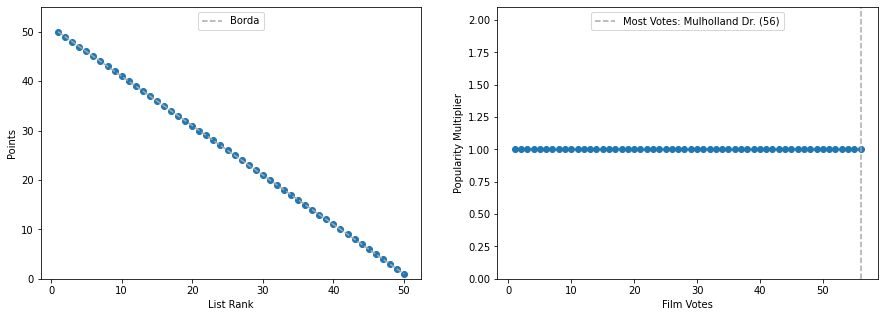

,,Rank,Score,Votes
ID,Title,,,
[Film288],Mulholland Dr.,1,2203.0,56
[Film1441],In the Mood for Love,2,1295.0,36
[Film68],There Will Be Blood,3,1287.0,35
[Film639],Spirited Away,4,1244.0,38
[Film1164],Yi Yi,5,1123.0,30
[Film153],No Country for Old Men,6,1074.0,34
[Film2338],Tropical Malady,7,1050.5,30
[Film2721],Love Exposure,8,1004.5,29
[Film7747],Syndromes and a Century,9,905.0,25


GridBox(children=(IntSlider(value=100, description='Results:', layout=Layout(width='350px'), max=1048, min=10,…

Output()

In [484]:
#@markdown Re-run this cell if the widgets disappear. If anything else breaks, try re-running all the cells, else contact me on RYM (YasashiiDia).

import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display

def hover(hover_color='silver'):
    return dict(selector="tr:hover", props=[("background-color", "%s" % hover_color)])

def alternate_row_colors(background_color='gainsboro'):
  return dict(selector='tr:nth-child(even)',props=[("background-color", "%s" % background_color)])

styles = [hover()]

def style_df(a):
    a_styled = a.style.set_properties(**{'text-align': 'center'})#.hide_index()
    a_styled = a_styled.format("{:.1f}",subset=['Score'])
    # #styles = [alternate_row_colors(),hover()]   
    #styles = [hover()] 
    #a_styled.set_table_styles(styles)

    return a_styled

def filt(vote_matrix, Results, Weight, PopWeight, Plot):

    if np.abs(PopWeight) <= 100:
      pop_multiplier = linear_pop_multiplier
    else:
      PopWeight -= np.sign(PopWeight)*100
      pop_multiplier = elliptical_pop_multiplier

    w_dist = list(np.linspace(0.1,0.9,10)) + list(np.linspace(1,5,11))
    Weight = w_dist[Weight+10]

    results = get_results_df(vote_matrix, Weight, PopWeight, pop_multiplier)

    if Plot:

      fig, ax = plt.subplots(1,2,figsize=(15,5))

      # Points
      x = np.arange(1,51)
      y = superellipse(x-1,n=Weight,a=1,b=1,size=MAX_LENGTH)
      ax[0].scatter(x, y)
      ax[0].plot([1,MAX_LENGTH],[MAX_LENGTH,1], label="Borda", ls="--",c="darkgrey")
      ax[0].set_xlabel("List Rank")
      ax[0].set_ylabel("Points")
      ax[0].set_ylim(0,1.1*MAX_LENGTH)

      # Popularity Weighting
      x = np.arange(1,MOST_VOTES+1)
      y = pop_multiplier(x, MOST_VOTES, PopWeight)
      ax[1].scatter(x,y)
      ax[1].set_xlabel("Film Votes")
      ax[1].set_ylabel("Popularity Multiplier")
      ax[1].set_ylim(0,2.1)
      ax[1].axvline(MOST_VOTES,ls="--",c="darkgrey",label=f"Most Votes: {MOST_VOTES_TITLE} ({MOST_VOTES})")
      
      for a in ax: a.legend(loc="upper center")
      plt.show()

    return results[["Rank","Score","Votes"]].sort_values(by="Rank")[:Results]

def display_df(Results,Weight,PopWeight,Plot,Display):

    a = filt(vote_matrix, Results, Weight,PopWeight, Plot)

    if Display == "DataFrame":
      a_styled = style_df(a)
      display(a_styled)

    elif Display == "RYM Print":
      for i in a.index:
        print(f"[b]{a.loc[i,'Rank']:.0f}.[/b] {i[0]} | Score: {a.loc[i,'Score']:.1f} | Votes: {a.loc[i,'Votes']:.0f}")

MAX_LENGTH = np.max(vote_matrix.values) # Maximum list length
COUNTS = vote_matrix.astype(bool).sum(axis=1)
MOST_VOTES_TITLE = COUNTS.sort_values().index[-1][1]
MOST_VOTES = max(COUNTS) # Number of votes of most voted entry

# Widgets
layout={'width': '350px'}
res_w = widgets.IntSlider(min=10, max=len(vote_matrix)+10, step=10,layout=layout,value=100,description='Results:')
pop_weight = widgets.IntSlider(min=-200, max=200, step=2,layout=layout,value=0,description='Pop Weight:')
top_weight = widgets.IntSlider(min=-10, max=10, step=1,layout=layout,value=0,description='Top Weight:')
plot_w = widgets.Checkbox(value=True,description='Plot Point Distribution')
display_w = widgets.Dropdown(options=['DataFrame','RYM Print'], value='DataFrame', description='Display:', disabled=False)

ws = [res_w,plot_w,display_w,display_w,top_weight,pop_weight]

out = widgets.interactive_output(display_df,{'Results':res_w,'Weight':top_weight,'PopWeight':pop_weight,"Plot":plot_w,"Display":display_w})
ui = widgets.GridBox(ws, layout=widgets.Layout(grid_template_columns="repeat(2, 400px)"))

display(ui, out)

# Neighbours

In [492]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display

def filt(Voter):

  c = vmc[Voter].sort_values(ascending=False)

  results = pd.DataFrame()
  results = pd.concat([results,pd.Series(c.values,name="Correlation")], axis=1, ignore_index=False)

  all_user_votes = []
  for v in c.index: 
    all_user_votes.append(pd.Series(vm[v][vm[v] > 0].sort_values().index.get_level_values(level="Title"), name=v))

  results = pd.concat([results]+all_user_votes, axis=1)
  results.index = c.index
  return results#.iloc[:10,:11]

def display_df(Voter):

  a = filt(Voter)
  #a_styled = style_df(a)
  #display(a_styled)
  display(a)

MAX_LENGTH = np.max(vote_matrix.values) # Maximum list length
COUNTS = vote_matrix.astype(bool).sum(axis=1)
MOST_VOTES_TITLE = COUNTS.sort_values().index[-1][1]
MOST_VOTES = max(COUNTS) # Number of votes of most voted entry

vote_matrix_all_ranked = vote_matrix.mask(vote_matrix < 0, 25.5)
vmc_ranked = vote_matrix_all_ranked.mask(vote_matrix_all_ranked>0, 51-vote_matrix_all_ranked).corr()
vmc_unranked = vote_matrix_all_ranked.mask(vote_matrix_all_ranked>0, 1).corr()

voters = list(vote_matrix_all_ranked.columns)
vmc = vmc_ranked
vm = vote_matrix_all_ranked

# Widgets
layout={'width': '350px'}
voter_w = widgets.Dropdown(options=voters, value=voters[0], description='Voter:', disabled=False)

ws = [voter_w]

out = widgets.interactive_output(display_df,{'Voter':voter_w})
ui = widgets.GridBox(ws, layout=widgets.Layout(grid_template_columns="repeat(2, 400px)"))

display(ui, out)

GridBox(children=(Dropdown(description='Voter:', options=('aflickering', 'AinsleyIscariot', 'Allyn', 'amanda_o…

Output()

In [488]:
import networkx as nx

links = vmc.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
 
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['value'] > 0.3) & (links['var1'] != links['var2']) ]
 
# Build graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

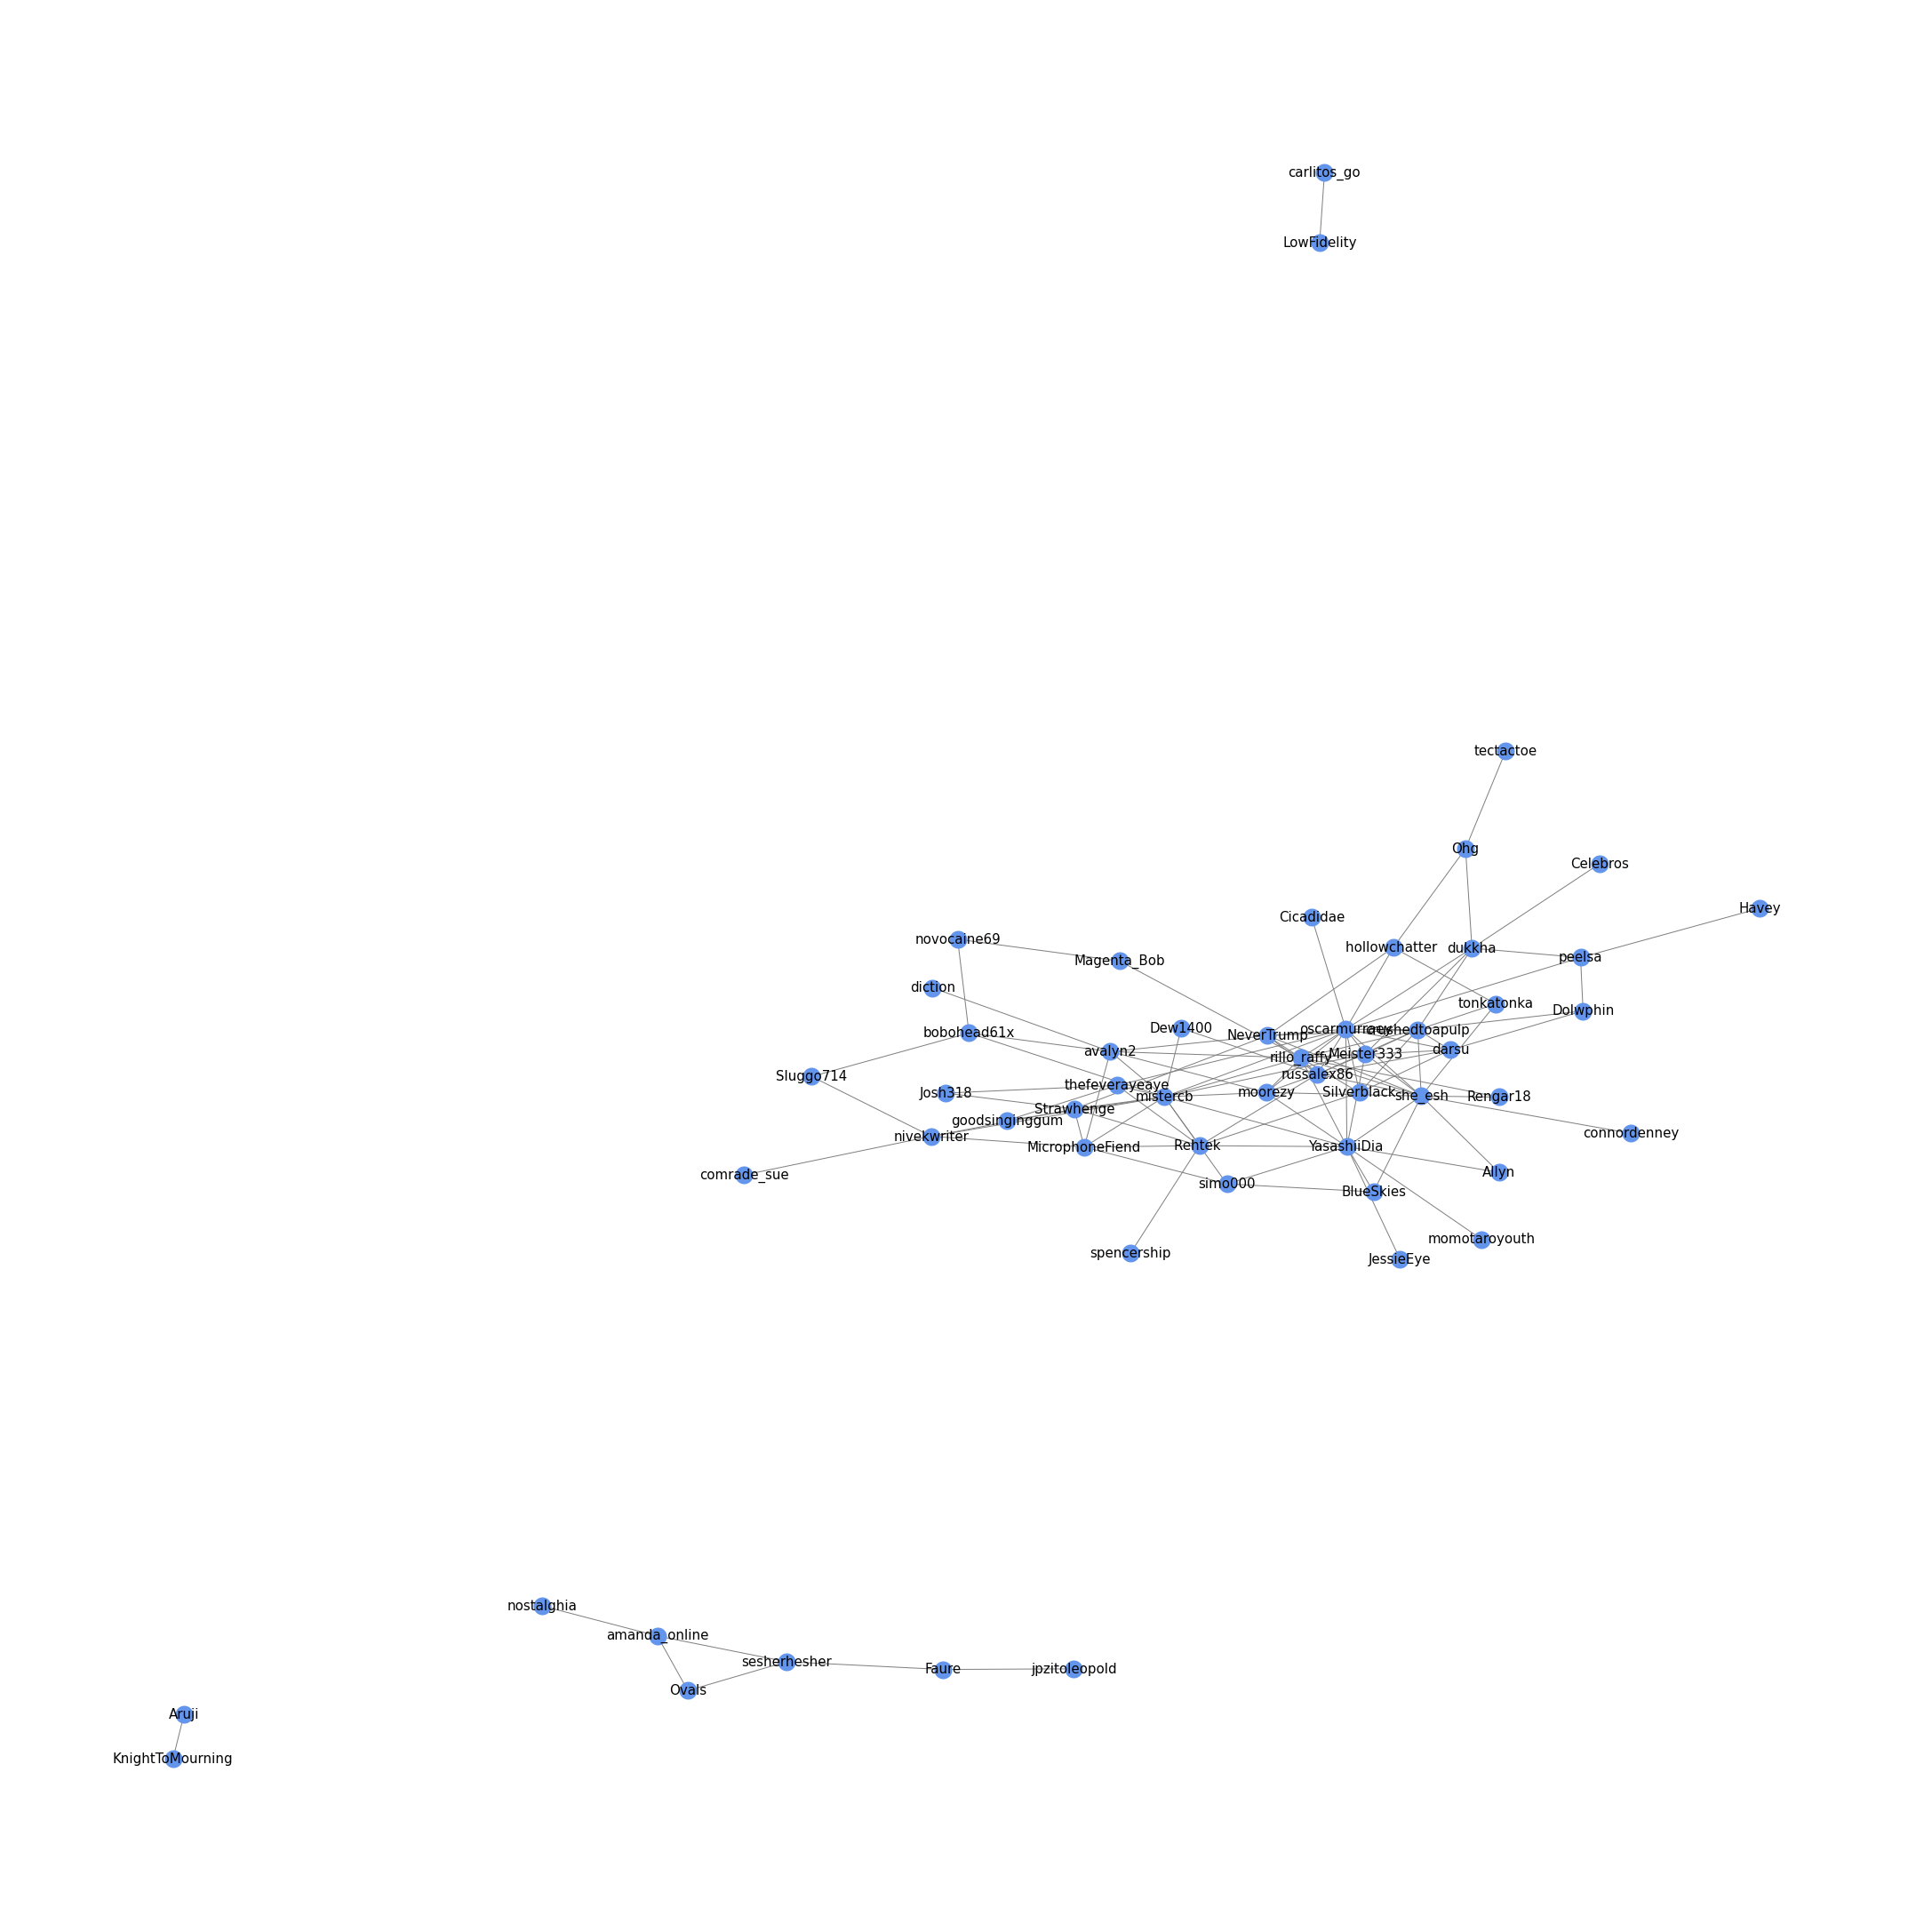

In [489]:
# Plot the network:
plt.figure(1,figsize=(30,30))
#nx.draw_kamada_kawai(G, with_labels=True, node_color='cornflowerblue', node_size=400, edge_color='grey', linewidths=0.01, font_size=15, font_color="black")
nx.draw(G, with_labels=True, node_color='cornflowerblue', node_size=400, edge_color='grey', linewidths=0.01, font_size=15, font_color="black")

In [ ]:
sns.clustermap(vmc_ranked.corr(), method="ward", robust=True)

In [490]:
a=vmc_ranked["YasashiiDia"].sort_values(ascending=False)

for v in a.index:
  print(f"{v}: {a.loc[v]:.2f}")

YasashiiDia: 1.00
simo000: 0.50
BlueSkies: 0.44
oscarmurraey: 0.42
she_esh: 0.40
mistercb: 0.36
momotaroyouth: 0.33
Rehtek : 0.32
Meister333: 0.32
JessieEye: 0.32
moorezy: 0.31
rillo_raffy: 0.31
Allyn: 0.30
MicrophoneFiend: 0.30
Jabbi: 0.29
Silverblack: 0.29
russalex86: 0.29
avalyn2: 0.28
nivekwriter: 0.27
tonkatonka: 0.27
bobohead61x: 0.26
darsu: 0.26
Rengar18: 0.26
goodsinginggum: 0.25
DtzaraD : 0.25
Sluggo714: 0.25
sesherhesher: 0.24
comrade_sue: 0.24
thefeverayeaye: 0.23
Cicadidae: 0.23
crushedtoapulp: 0.22
diction: 0.21
Dew1400: 0.21
daevalis: 0.20
Strawhenge: 0.20
astadaradim: 0.19
Stoicorum: 0.18
AinsleyIscariot: 0.18
Ohg: 0.18
hollowchatter : 0.17
spencership: 0.17
RuthJanelle: 0.17
NeverTrump: 0.17
connordenney: 0.17
aflickering: 0.16
tectactoe: 0.16
tuukkis: 0.15
Aruji: 0.15
novocaine69: 0.15
Magenta_Bob: 0.15
LifeDuringWartime: 0.14
dukkha: 0.14
KnightToMourning: 0.14
Jag114: 0.13
Faure: 0.13
jpzitoleopold: 0.13
Dolwphin: 0.12
carlitos_go: 0.12
Cubbierill: 0.12
Bach: 0.12
Ce

In [491]:
(vmc.min(axis=1).idxmin(), vmc.min().idxmin())

('LifeDuringWartime', 'LifeDuringWartime')